<a href="https://colab.research.google.com/github/allancfb/TCC_UNIRIO/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INIT

In [ ]:
'''https://www.kaggle.com/code/sana306/detection-of-covid-positive-cases-using-dl/notebook#Exploratory-Data-Analysis'''

# imports
from google.colab import drive
import requests
import shutil
import zipfile
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ModelCheckpoint
from keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, precision_score, f1_score, accuracy_score
from keras.optimizers import Adam
import tensorflow as tf
import time
import albumentations as A
from sklearn.utils import class_weight
from keras import backend as K
import seaborn as sns
from keras.applications import ResNet50
from keras.layers import Input
from tensorflow.python import metrics
import math
from keras.applications import DenseNet201
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model

In [ ]:
# extract dataset
drive_dataset_path = "drive/MyDrive/TCC/dataset" #Allan
dataset_source_path = 'source'
dataset_path = 'dataset'

zip_path = os.path.join(dataset_source_path, 'archive.zip')

try:
  shutil.rmtree('sample_data')
except:
  pass

drive.mount('/content/drive', force_remount=True)

shutil.rmtree(dataset_source_path, ignore_errors=True)
shutil.copytree(drive_dataset_path, dataset_source_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(dataset_source_path)

dataset_source_path = os.path.join(dataset_source_path, 'COVID-19_Radiography_Dataset')

os.remove(zip_path)

Mounted at /content/drive


In [ ]:
def read_dataset():
  data_folder = 'images'
  global levels
  global dataset_source_path
  dataset_path = dataset_source_path
  global img_size
  global channels

  global x
  global y

  x = []
  y = []

  for level in levels:
    for file in os.listdir(os.path.join(dataset_path, level, data_folder)):
      file_path = '{}/{}/{}'.format(level, data_folder, file)

      #Aqui estamos verificando se é grayscale ou RGB
      # channels == 1 significa que é Grayscale
      if channels == 1:
        x.append(cv2.resize(cv2.imread(os.path.join(dataset_path, file_path), 0), (img_size, img_size)) / 255.0)
      else:
        x.append(cv2.resize(cv2.imread(os.path.join(dataset_path, file_path)), (img_size, img_size)) / 255.0)

      y.append(levels.index(level))

  x = np.array(x)
  y = np.array(y)

  plot_dataset(y, 'Dataset Completo')

def read_dataset_v2():
  data_folder = 'images'
  global levels
  global dataset_source_path
  global dataset_path
  global img_size
  global batch_size
  global channels
  global n_classes

  global train_dataset
  global val_dataset

  try:
    shutil.rmtree(dataset_path)
  except:
    pass

  for level in levels:
    source_level_path = os.path.join(dataset_source_path, level, data_folder)
    level_path = os.path.join(dataset_path, level)

    shutil.copytree(source_level_path, level_path)
  
  color_mode = ''
  label_mode = ''

  if channels == 1:
    color_mode = 'grayscale'
  elif channels == 3:
    color_mode = 'rgb'

  '''
  if n_classes == 2:
    label_mode = 'binary'
  else:
    label_mode = 'categorical'
  '''
  label_mode = 'categorical'

  train_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode=color_mode,
    label_mode=label_mode,
    labels='inferred')
  
  val_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode=color_mode,
    label_mode=label_mode,
    labels='inferred')
  
  normalization_layer = layers.Rescaling(1./255)
  train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
  val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  
  for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    break

def format_dataset(balance=False):
  split_dataset()

  if balance:
    balance_dataset()

  reshape_dataset()
  to_categorical()

def split_dataset():
  global x
  global y
  global test_size
  global validation_size

  global x_train
  global x_test
  global y_train
  global y_test
  global x_val
  global y_val
  global y_train_source

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 42, stratify=y)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = validation_size, random_state = 42, stratify=y_train)

  y_train_source = y_train

  plot_dataset(y_train, 'Dataset de Treino')

  #Economizar memória
  del x, y

def reshape_dataset():
  global x_train
  global img_size
  global channels
  global x_val

  x_train = x_train.reshape(x_train.shape[0], img_size, img_size, channels).astype('float32')
  x_val = x_val.reshape(x_val.shape[0], img_size, img_size, channels).astype('float32')

#Preparar o Dataset para a classificação
def to_categorical():
  global y_train
  global n_classes
  global y_val

  y_train = keras.utils.to_categorical(y_train, n_classes)
  y_val = keras.utils.to_categorical(y_val, n_classes)

def train_model(fit_type='default'):
  global learning_rate
  global model
  global learning_patience
  global x_train
  global y_train
  global epochs
  global batch_size
  global x_val
  global y_val

  global history
  global yp_train
  global yp_val
  global yp_test

  opt = Adam(learning_rate=learning_rate)

  #model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])
  #model.compile(loss=[focal_loss(alpha=.25, gamma=2)], optimizer = opt, metrics=['accuracy'])

  model.compile(loss=FocalLoss, optimizer = opt, metrics=['accuracy'])

  es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = learning_patience)

  #Aqui pode dar erro ao passar multiplos argumentos no callback
  #https://forums.fast.ai/t/passing-multiple-callbacks-in-keras-early-stopping-modelcheckpoint-lrratescheduler/5477/12
  '''
  checkpoint_filepath = './tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)'''
  
  start_time = time.time()

  if fit_type == 'default':
    history = model.fit(x_train, y_train, 
                          epochs = epochs, batch_size = batch_size,  
                          validation_data = (x_val, y_val),
                          #callbacks = [es,model_checkpoint_callback]
                          callbacks = [es])
  elif fit_type == 'class':
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_source), y=y_train_source)
    class_weights_dict = dict(enumerate(class_weights))
    #class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    #sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_source)

    history = model.fit(x_train, y_train, 
                          epochs = epochs, batch_size = batch_size,  
                          validation_data = (x_val, y_val),
                          #callbacks = [es,model_checkpoint_callback]
                          callbacks = [es],
                          class_weight=class_weights_dict)
  
  training_time = time.time() - start_time
  print("Tempo de treino: {:.2f} segundos".format(training_time))
  #evaluation_parametrics()
  
def train():
  train_model()

def train_class_weight():
  train_model(fit_type='class')

def train_v2():
  global train_dataset
  global val_dataset
  global epochs
  global model
  global learning_patience

  global history

  opt = Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = learning_patience)

  history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks = [es]
  )
  
def show():
  global history

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Acurácia do Modelo')
  plt.ylabel('Porcentagem')
  plt.xlabel('Época')
  plt.legend(['Acurácia de Treino', 'Acurácia de Validação'], loc = 'upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss do Modelo')
  plt.ylabel('Porcentagem')
  plt.xlabel('Época')
  plt.legend(['Loss de Treino', 'Loss de Validação'], loc = 'lower left')
  plt.show()

  evaluate_model()

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
  targets = K.cast(targets, 'float32')

  BCE = K.binary_crossentropy(targets, inputs)
  BCE_EXP = K.exp(-BCE)
  focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
  
  return focal_loss

def evaluate_model():
  global model
  global x_val
  global y_val
  global x_test
  global y_test
  global levels

  baseline_results = model.evaluate(x_val, y_val, verbose=0)

  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

  yp_test = model.predict(x_test, verbose=0)
  yp_test = np.argmax(yp_test, axis = 1)

  cm_test = confusion_matrix(y_test, yp_test)
  t = ConfusionMatrixDisplay(cm_test, display_labels=list(map(lambda x: x.replace('_', ' ').split(' ')[-1], levels)))

  t.plot()

def plot_dataset(y, title):
  global levels

  global count_levels

  df = pd.DataFrame()
  df['resultado'] = levels

  count_levels = []

  for index in range(len(levels)):
    count_levels.append(np.count_nonzero(y == index))

  df['quantidade'] = count_levels
  df = df.sort_values(by = ['quantidade'], ascending = False)

  fig = px.bar(df, x = 'resultado', y = 'quantidade', 
              color = "resultado", text_auto='', width = 600, 
              #color_discrete_sequence = ["orange", "purple"],
              template = 'plotly_dark', title=title)

  fig.update_xaxes(showgrid = False)
  fig.update_yaxes(showgrid = False)
  fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

  fig.show()

def balance_dataset():
  global levels
  global x_train
  global y_train

  x_train_augmented = []
  y_train_augmented = []

  for i in range(len(levels)):
    for j in range(math.floor((max(count_levels) // count_levels[i]) - 1)):
      for k in range(len(x_train)):
        if y_train[k] == i:
          x_train_augmented.append(augment_data(x_train[k]))
          y_train_augmented.append(i)

  x_train = np.concatenate((x_train, np.array(x_train_augmented)))
  y_train = np.concatenate((y_train, np.array(y_train_augmented)))

  plot_dataset(y_train, 'Dataset de Treino Balaceado')

def augment_data(img):
  # Random horizontal flipping
  if np.random.rand() < 0.5:
    img = cv2.flip(img, 1)

  # Random rotation with a max angle of 15 degrees
  angle = np.random.uniform(-15, 15)
  rows, cols = img.shape[:2]
  M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
  img = cv2.warpAffine(img, M, (cols,rows))

  # Random translation with a max offset of 5 pixels in both x and y directions
  x_offset = np.random.randint(-5, 5)
  y_offset = np.random.randint(-5, 5)
  M = np.float32([[1,0,x_offset],[0,1,y_offset]])
  img = cv2.warpAffine(img, M, (cols,rows))

  return img

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

'''
def random_rotation(image, angle_range):
    rows, cols, ch = image.shape
    angle = np.random.uniform(-angle_range, angle_range)
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))

    return image

def random_flip(image):
    #if np.random.random() > 0.5:
    image = cv2.flip(image, 1)  # 1 = horizontal

    return image

def balance_dataset():
  global x_train
  global y_train

  for i in range(len(x_train)):
    x_augmented, y_augmented= augment_image(i)
  
  x_train = np.concatenate((x_train, np.array(x_augmented)))
  y_train = np.concatenate((y_train, np.array(y_augmented)))

def augment_image(i):
  global x_train_image

  x_augmented = []
  y_augmented = []

  if n_classes == 2:
    c0 = sum(1 for x in y_train if x == 0)
    c1 = sum(1 for x in y_train if x == 1)

    proportion = 0.0

    if c0 > c1:
      menor = 1
      proportion = c0/c1
    else:
      menor = 0
      proportion = c1/c0
    
    multiplier = 0

    if y_train[i] == menor:
      if proportion >= 2.5:
        x_train_image = random_rotation(x_train[i], 30)
        x_augmented.append(x_train_image)
        y_augmented.append(y_train[i])

        x_train_image = random_flip(x_train_image)
        x_augmented.append(x_train_image)
        y_augmented.append(y_train[i])
      elif proportion >= 1.5:
        if np.random.random() > 0.5:
          x_train_image = random_rotation(x_train[i], 30)
          x_augmented.append(x_train_image)
          y_augmented.append(y_train[i])
        else:
          x_train_image = random_flip(x_train_image)
          x_augmented.append(x_train_image)
          y_augmented.append(y_train[i])
  elif n_classes == 3:

          
  return x_augmented, y_augmented
'''

'\ndef random_rotation(image, angle_range):\n    rows, cols, ch = image.shape\n    angle = np.random.uniform(-angle_range, angle_range)\n    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)\n    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))\n\n    return image\n\ndef random_flip(image):\n    #if np.random.random() > 0.5:\n    image = cv2.flip(image, 1)  # 1 = horizontal\n\n    return image\n\ndef balance_dataset():\n  global x_train\n  global y_train\n\n  for i in range(len(x_train)):\n    x_augmented, y_augmented= augment_image(i)\n  \n  x_train = np.concatenate((x_train, np.array(x_augmented)))\n  y_train = np.concatenate((y_train, np.array(y_augmented)))\n\ndef augment_image(i):\n  global x_train_image\n\n  x_augmented = []\n  y_augmented = []\n\n  if n_classes == 2:\n    c0 = sum(1 for x in y_train if x == 0)\n    c1 = sum(1 for x in y_train if x == 1)\n\n    proportion = 0.0\n\n    if c0 > c1:\n      menor = 1\n      proportion = c0/c1\n    else:\n 

# DATA AUGMENTATION EXAMPLE

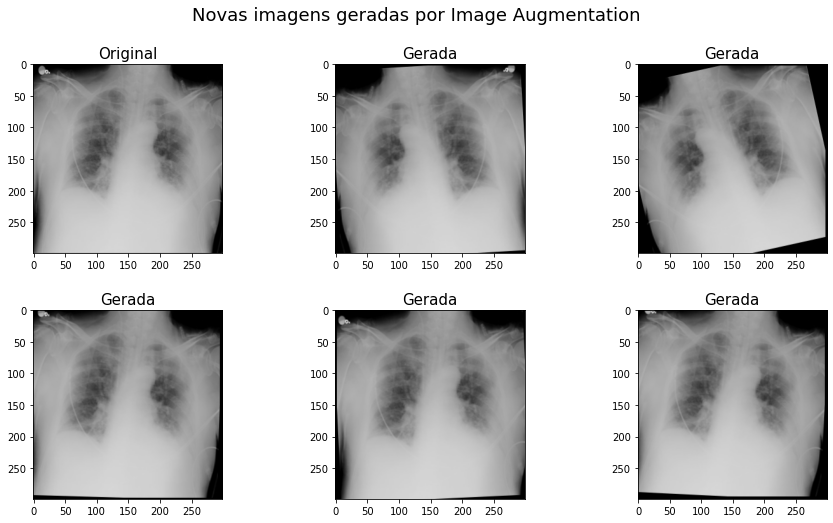

In [ ]:
file_path = 'COVID/images/COVID-1.png'
dataset_path = dataset_source_path

img = cv2.imread(os.path.join(dataset_path, file_path))

img_matrix_list = []
img_matrix_list.append(img)

for i in range(5):
  img_matrix_list.append(augment_data(img))

bboxes_list = []  

titles_list = ["Original", "Gerada", "Gerada", "Gerada", "Gerada", "Gerada"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 3, main_title = "Novas imagens geradas por Image Augmentation")


# LENET GRAYSCALE: 3 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

#read_dataset_v2()
read_dataset()
format_dataset()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
#train_v2()
train()

Epoch 1/2000
43/43 [==============================] - 1s 9ms/step - loss: 0.0921 - accuracy: 0.6877 - val_loss: 0.0701 - val_accuracy: 0.7791
Epoch 2/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0692 - accuracy: 0.7782 - val_loss: 0.0614 - val_accuracy: 0.8170
Epoch 3/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0607 - accuracy: 0.8180 - val_loss: 0.0517 - val_accuracy: 0.8434
Epoch 4/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0538 - accuracy: 0.8418 - val_loss: 0.0473 - val_accuracy: 0.8582
Epoch 5/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0490 - accuracy: 0.8591 - val_loss: 0.0435 - val_accuracy: 0.8706
Epoch 6/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0463 - accuracy: 0.8627 - val_loss: 0.0426 - val_accuracy: 0.8648
Epoch 7/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0435 - accuracy: 0.8717 - val_loss: 0.0392 - val_accuracy: 0.8821
Epoch 

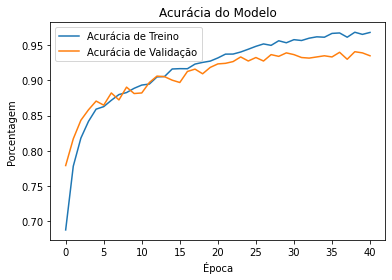

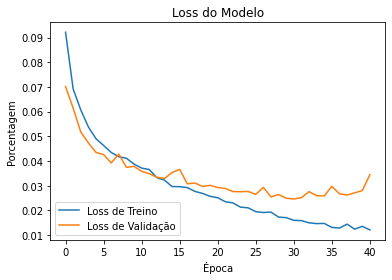

loss :  0.03449653834104538
accuracy :  0.9348722100257874


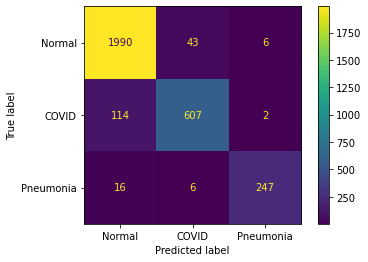

In [ ]:
show()

# LENET GRAYSCALE: 3 CATEGORIES BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

#read_dataset_v2()
read_dataset()
format_dataset(balance=True)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
#train_v2()
train()

Epoch 1/2000
76/76 [==============================] - 1s 7ms/step - loss: 0.0811 - accuracy: 0.7411 - val_loss: 0.0668 - val_accuracy: 0.7947
Epoch 2/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0570 - accuracy: 0.8364 - val_loss: 0.0657 - val_accuracy: 0.7964
Epoch 3/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0494 - accuracy: 0.8624 - val_loss: 0.0541 - val_accuracy: 0.8392
Epoch 4/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0437 - accuracy: 0.8788 - val_loss: 0.0507 - val_accuracy: 0.8409
Epoch 5/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0397 - accuracy: 0.8916 - val_loss: 0.0446 - val_accuracy: 0.8656
Epoch 6/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0361 - accuracy: 0.9027 - val_loss: 0.0435 - val_accuracy: 0.8673
Epoch 7/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0345 - accuracy: 0.9062 - val_loss: 0.0400 - val_accuracy: 0.8871
Epoch 

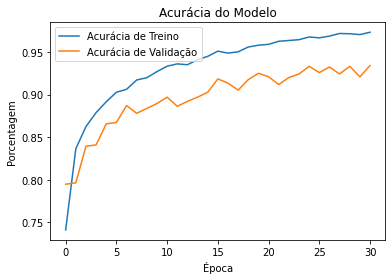

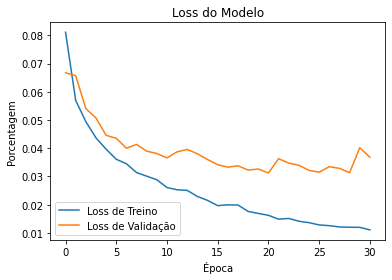

loss :  0.03681180998682976
accuracy :  0.9340478181838989


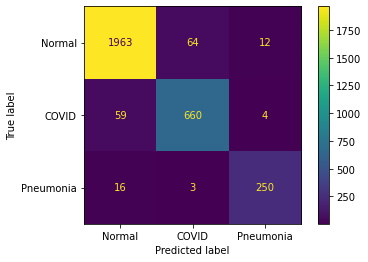

In [ ]:
show()

# LENET GRAYSCALE: 3 CATEGORIES WITH CLASS WEIGHT

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

#read_dataset_v2()
read_dataset()
format_dataset()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
#train_v2()
train_class_weight()

Epoch 1/2000
43/43 [==============================] - 1s 10ms/step - loss: 0.0904 - accuracy: 0.6929 - val_loss: 0.0694 - val_accuracy: 0.7873
Epoch 2/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0682 - accuracy: 0.7895 - val_loss: 0.0599 - val_accuracy: 0.8269
Epoch 3/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0587 - accuracy: 0.8222 - val_loss: 0.0566 - val_accuracy: 0.8145
Epoch 4/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0538 - accuracy: 0.8404 - val_loss: 0.0523 - val_accuracy: 0.8302
Epoch 5/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0496 - accuracy: 0.8559 - val_loss: 0.0466 - val_accuracy: 0.8574
Epoch 6/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0464 - accuracy: 0.8644 - val_loss: 0.0516 - val_accuracy: 0.8483
Epoch 7/2000
43/43 [==============================] - 0s 5ms/step - loss: 0.0439 - accuracy: 0.8712 - val_loss: 0.0436 - val_accuracy: 0.8673
Epoch

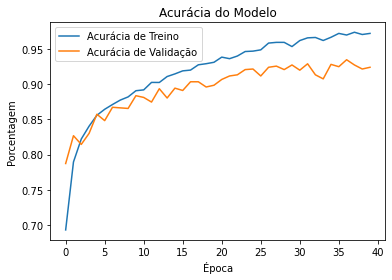

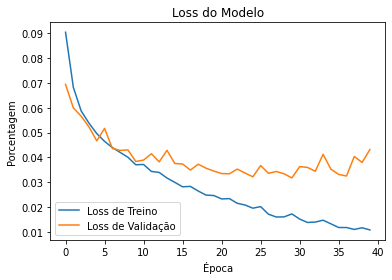

loss :  0.04311959072947502
accuracy :  0.9241549968719482


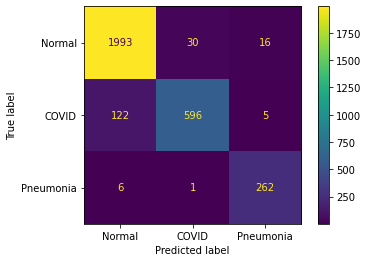

In [ ]:
show()

# LENET GRAYSCALE: 3 CATEGORIES WITH CLASS WEIGHT BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

#read_dataset_v2()
read_dataset()
format_dataset(balance=True)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_40 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_17 (Flatten)        (None, 9216)              0         
                                                                 
 dense_34 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
#train_v2()
train_class_weight()

Epoch 1/2000
76/76 [==============================] - 1s 7ms/step - loss: 0.1573 - accuracy: 0.7384 - val_loss: 0.0657 - val_accuracy: 0.7997
Epoch 2/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.1080 - accuracy: 0.8356 - val_loss: 0.0612 - val_accuracy: 0.8096
Epoch 3/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0953 - accuracy: 0.8569 - val_loss: 0.0543 - val_accuracy: 0.8384
Epoch 4/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0840 - accuracy: 0.8744 - val_loss: 0.0492 - val_accuracy: 0.8516
Epoch 5/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0770 - accuracy: 0.8871 - val_loss: 0.0491 - val_accuracy: 0.8442
Epoch 6/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.8962 - val_loss: 0.0454 - val_accuracy: 0.8533
Epoch 7/2000
76/76 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.9070 - val_loss: 0.0423 - val_accuracy: 0.8697
Epoch 

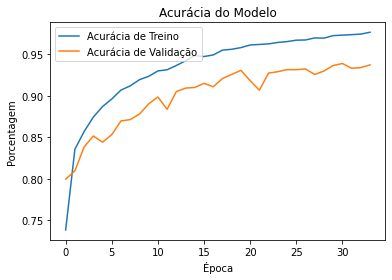

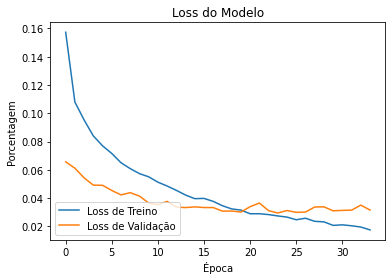

loss :  0.031573329120874405
accuracy :  0.9373454451560974


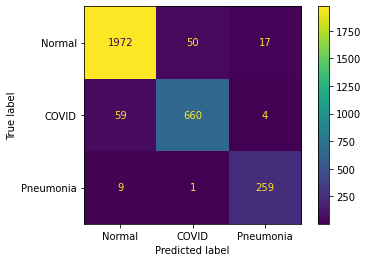

In [ ]:
show()

# LENET RGB: 3 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

#read_dataset_v2()
read_dataset()
format_dataset()

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
#train_v2()
train()

Epoch 1/2000
43/43 [==============================] - 1s 10ms/step - loss: 0.1037 - accuracy: 0.6678 - val_loss: 0.0740 - val_accuracy: 0.7354
Epoch 2/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0750 - accuracy: 0.7526 - val_loss: 0.0657 - val_accuracy: 0.8005
Epoch 3/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0667 - accuracy: 0.7916 - val_loss: 0.0574 - val_accuracy: 0.8219
Epoch 4/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0591 - accuracy: 0.8169 - val_loss: 0.0509 - val_accuracy: 0.8566
Epoch 5/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0544 - accuracy: 0.8365 - val_loss: 0.0472 - val_accuracy: 0.8640
Epoch 6/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0496 - accuracy: 0.8542 - val_loss: 0.0457 - val_accuracy: 0.8574
Epoch 7/2000
43/43 [==============================] - 0s 6ms/step - loss: 0.0469 - accuracy: 0.8603 - val_loss: 0.0434 - val_accuracy: 0.8697
Epoch

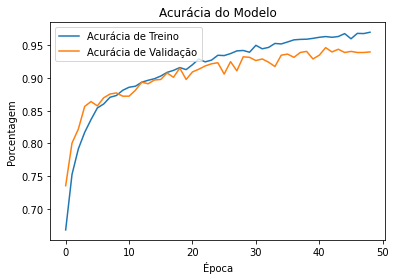

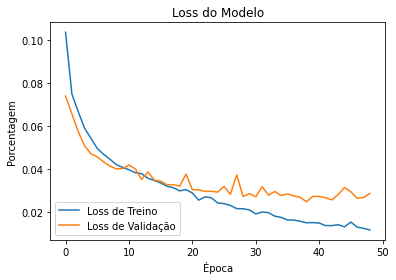

loss :  0.02858704887330532
accuracy :  0.9398186206817627


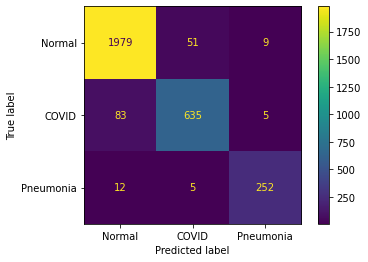

In [ ]:
show()

# LENET GRAYSCALE: 4 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 28, 28, 1)
(1694, 28, 28, 1)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
train()

Epoch 1/2000
60/60 [==============================] - 1s 8ms/step - loss: 0.0913 - accuracy: 0.5723 - val_loss: 0.0707 - val_accuracy: 0.7113
Epoch 2/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0730 - accuracy: 0.6899 - val_loss: 0.0625 - val_accuracy: 0.7538
Epoch 3/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0658 - accuracy: 0.7293 - val_loss: 0.0579 - val_accuracy: 0.7597
Epoch 4/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0604 - accuracy: 0.7583 - val_loss: 0.0527 - val_accuracy: 0.7839
Epoch 5/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0567 - accuracy: 0.7772 - val_loss: 0.0504 - val_accuracy: 0.8076
Epoch 6/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0538 - accuracy: 0.7879 - val_loss: 0.0487 - val_accuracy: 0.8111
Epoch 7/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0513 - accuracy: 0.7981 - val_loss: 0.0462 - val_accuracy: 0.8140
Epoch 

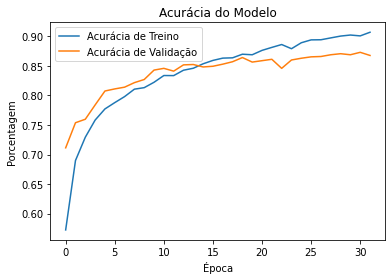

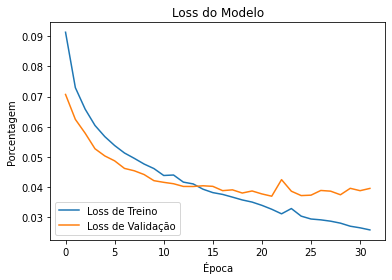

loss :  0.03960046544671059
accuracy :  0.8677685856819153


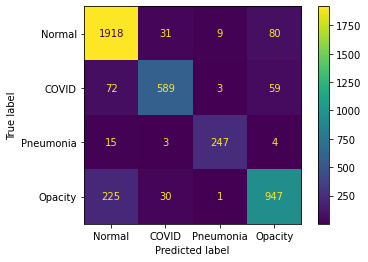

In [ ]:
show()

# LENET GRAYSCALE: 4 CATEGORIES BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(23650, 28, 28, 1)
(1694, 28, 28, 1)
(23650, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1179776   
                                                      

In [ ]:
train()

Epoch 1/2000
93/93 [==============================] - 1s 7ms/step - loss: 0.0823 - accuracy: 0.6375 - val_loss: 0.0710 - val_accuracy: 0.7113
Epoch 2/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0597 - accuracy: 0.7611 - val_loss: 0.0661 - val_accuracy: 0.7166
Epoch 3/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0537 - accuracy: 0.7898 - val_loss: 0.0584 - val_accuracy: 0.7633
Epoch 4/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0493 - accuracy: 0.8125 - val_loss: 0.0555 - val_accuracy: 0.7763
Epoch 5/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0461 - accuracy: 0.8252 - val_loss: 0.0518 - val_accuracy: 0.8005
Epoch 6/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0429 - accuracy: 0.8401 - val_loss: 0.0505 - val_accuracy: 0.7952
Epoch 7/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0414 - accuracy: 0.8453 - val_loss: 0.0489 - val_accuracy: 0.8081
Epoch 

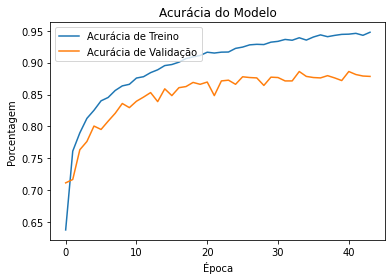

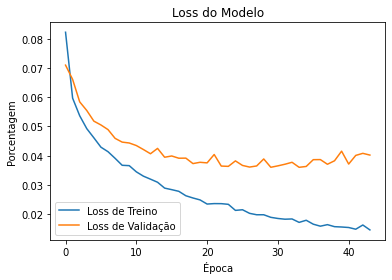

loss :  0.04020180180668831
accuracy :  0.8783943057060242


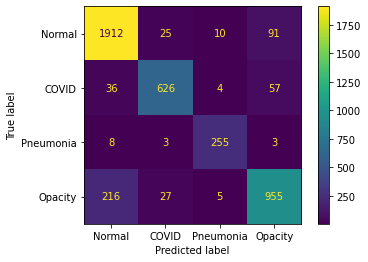

In [ ]:
show()

# LENET GRAYSCALE: 4 CATEGORIES WITH CLASS WEIGHT

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 28, 28, 1)
(1694, 28, 28, 1)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               1179776   
                                                      

In [ ]:
train_class_weight()

Epoch 1/2000
60/60 [==============================] - 1s 8ms/step - loss: 0.0936 - accuracy: 0.5572 - val_loss: 0.0744 - val_accuracy: 0.6570
Epoch 2/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0736 - accuracy: 0.6897 - val_loss: 0.0628 - val_accuracy: 0.7503
Epoch 3/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0666 - accuracy: 0.7254 - val_loss: 0.0576 - val_accuracy: 0.7668
Epoch 4/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0616 - accuracy: 0.7515 - val_loss: 0.0558 - val_accuracy: 0.7780
Epoch 5/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0579 - accuracy: 0.7716 - val_loss: 0.0545 - val_accuracy: 0.7721
Epoch 6/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0555 - accuracy: 0.7798 - val_loss: 0.0495 - val_accuracy: 0.8005
Epoch 7/2000
60/60 [==============================] - 0s 5ms/step - loss: 0.0539 - accuracy: 0.7871 - val_loss: 0.0526 - val_accuracy: 0.8046
Epoch 

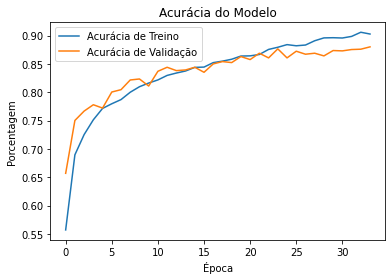

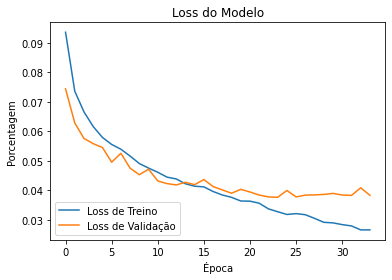

loss :  0.038309525698423386
accuracy :  0.8801652789115906


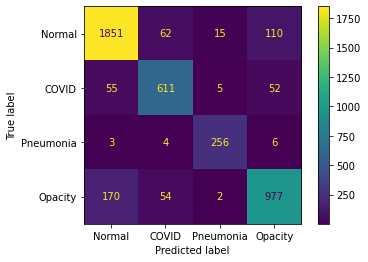

In [ ]:
show()

# LENET GRAYSCALE: 4 CATEGORIES WITH CLASS WEIGHT BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(23650, 28, 28, 1)
(1694, 28, 28, 1)
(23650, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_42 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_18 (Flatten)        (None, 9216)              0         
                                                                 
 dense_36 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
train_class_weight()

Epoch 1/2000
93/93 [==============================] - 1s 7ms/step - loss: 0.1523 - accuracy: 0.6241 - val_loss: 0.0738 - val_accuracy: 0.6966
Epoch 2/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.1088 - accuracy: 0.7570 - val_loss: 0.0637 - val_accuracy: 0.7338
Epoch 3/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0952 - accuracy: 0.7951 - val_loss: 0.0608 - val_accuracy: 0.7698
Epoch 4/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0880 - accuracy: 0.8135 - val_loss: 0.0571 - val_accuracy: 0.7816
Epoch 5/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0828 - accuracy: 0.8274 - val_loss: 0.0541 - val_accuracy: 0.7774
Epoch 6/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0781 - accuracy: 0.8371 - val_loss: 0.0506 - val_accuracy: 0.8111
Epoch 7/2000
93/93 [==============================] - 0s 5ms/step - loss: 0.0739 - accuracy: 0.8467 - val_loss: 0.0471 - val_accuracy: 0.8223
Epoch 

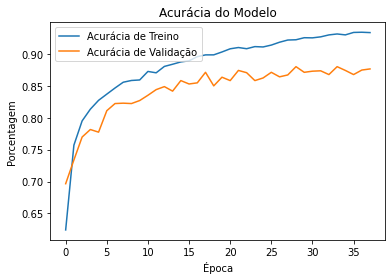

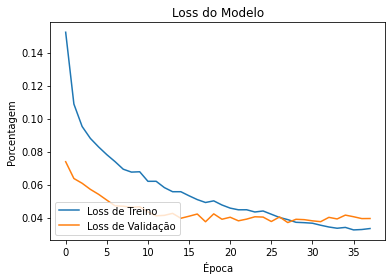

loss :  0.039403557777404785
accuracy :  0.8766233921051025


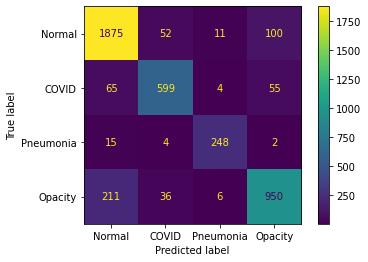

In [ ]:
show()

# LENET RGB: 4 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 28, 28, 3)
(1694, 28, 28, 3)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1179776   
                                                      

In [ ]:
train()

Epoch 1/2000
60/60 [==============================] - 1s 9ms/step - loss: 0.0893 - accuracy: 0.6019 - val_loss: 0.0689 - val_accuracy: 0.7178
Epoch 2/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0702 - accuracy: 0.7110 - val_loss: 0.0671 - val_accuracy: 0.7084
Epoch 3/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0639 - accuracy: 0.7433 - val_loss: 0.0553 - val_accuracy: 0.7698
Epoch 4/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0588 - accuracy: 0.7661 - val_loss: 0.0519 - val_accuracy: 0.7845
Epoch 5/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.7851 - val_loss: 0.0528 - val_accuracy: 0.7745
Epoch 6/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0527 - accuracy: 0.7944 - val_loss: 0.0472 - val_accuracy: 0.8164
Epoch 7/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.8071 - val_loss: 0.0472 - val_accuracy: 0.8146
Epoch 

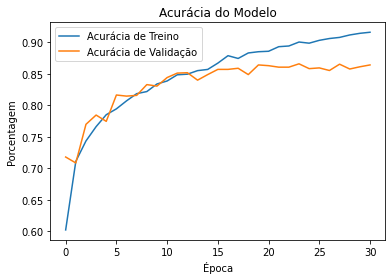

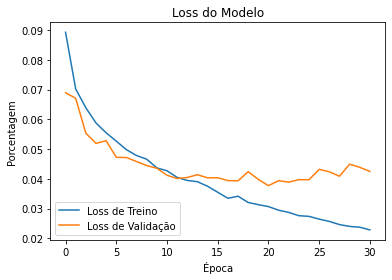

loss :  0.04250328987836838
accuracy :  0.8642266988754272


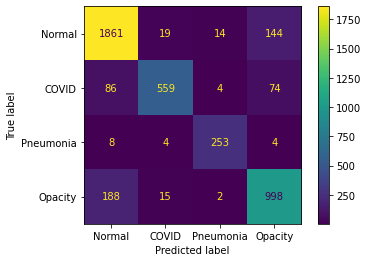

In [ ]:
show()

# LENET RGB: 4 CATEGORIES WITH CLASS WEIGHT

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 28, 28, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 28, 28, 3)
(1694, 28, 28, 3)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 9216)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1179776   
                                                      

In [ ]:
train_class_weight()

Epoch 1/2000
60/60 [==============================] - 1s 9ms/step - loss: 0.0959 - accuracy: 0.5549 - val_loss: 0.0742 - val_accuracy: 0.6795
Epoch 2/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0750 - accuracy: 0.6803 - val_loss: 0.0632 - val_accuracy: 0.7462
Epoch 3/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0671 - accuracy: 0.7223 - val_loss: 0.0587 - val_accuracy: 0.7568
Epoch 4/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0625 - accuracy: 0.7447 - val_loss: 0.0560 - val_accuracy: 0.7751
Epoch 5/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0599 - accuracy: 0.7636 - val_loss: 0.0540 - val_accuracy: 0.7810
Epoch 6/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.7756 - val_loss: 0.0514 - val_accuracy: 0.7999
Epoch 7/2000
60/60 [==============================] - 0s 6ms/step - loss: 0.0552 - accuracy: 0.7827 - val_loss: 0.0492 - val_accuracy: 0.8111
Epoch 

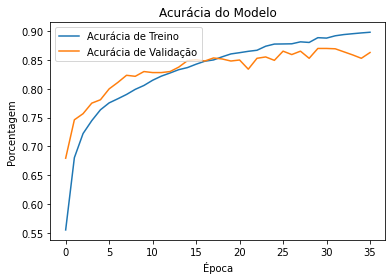

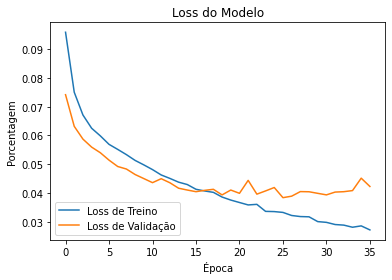

loss :  0.04226589947938919
accuracy :  0.8630460500717163


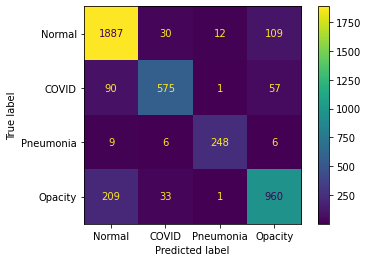

In [ ]:
show()

# LENET GRAYSCALE: COVID OR NORMAL



In [ ]:
levels = ['Normal', 'COVID']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 28, 28)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 28, 28, 1)
(1105, 28, 28, 1)
(9941, 2)
(1105, 2)


In [ ]:
'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
'''

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_8 (Flatten)         (None, 9216)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               1179776   
                                                      

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 1s 11ms/step - loss: 0.1150 - accuracy: 0.7263 - val_loss: 0.0942 - val_accuracy: 0.7385
Epoch 2/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0914 - accuracy: 0.7912 - val_loss: 0.0815 - val_accuracy: 0.8100
Epoch 3/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0801 - accuracy: 0.8304 - val_loss: 0.0720 - val_accuracy: 0.8480
Epoch 4/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.8447 - val_loss: 0.0720 - val_accuracy: 0.8389
Epoch 5/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0683 - accuracy: 0.8589 - val_loss: 0.0605 - val_accuracy: 0.8742
Epoch 6/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.8682 - val_loss: 0.0583 - val_accuracy: 0.8796
Epoch 7/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0591 - accuracy: 0.8763 - val_loss: 0.0547 - val_accuracy: 0.8842
Epoch

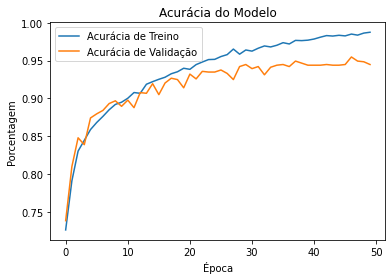

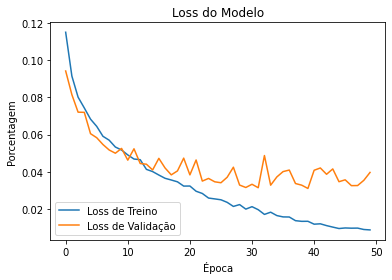

loss :  0.03966088965535164
accuracy :  0.9447963833808899


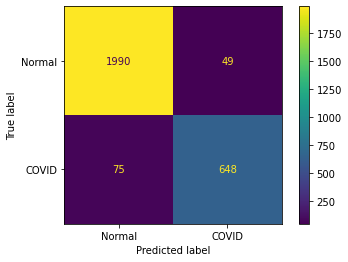

In [ ]:
show()

# LENET GRAYSCALE: COVID OR NORMAL BALANCED



In [ ]:
levels = ['Normal', 'COVID']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 28, 28)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12545, 28, 28, 1)
(1105, 28, 28, 1)
(12545, 2)
(1105, 2)


In [ ]:
'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
'''

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_9 (Flatten)         (None, 9216)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
train()

Epoch 1/2000
50/50 [==============================] - 1s 9ms/step - loss: 0.1083 - accuracy: 0.7347 - val_loss: 0.0973 - val_accuracy: 0.7937
Epoch 2/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0815 - accuracy: 0.8323 - val_loss: 0.0926 - val_accuracy: 0.7801
Epoch 3/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0723 - accuracy: 0.8506 - val_loss: 0.0740 - val_accuracy: 0.8317
Epoch 4/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0655 - accuracy: 0.8662 - val_loss: 0.1162 - val_accuracy: 0.7611
Epoch 5/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0791 - accuracy: 0.8329 - val_loss: 0.0780 - val_accuracy: 0.8271
Epoch 6/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0668 - accuracy: 0.8659 - val_loss: 0.0696 - val_accuracy: 0.8588
Epoch 7/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0586 - accuracy: 0.8834 - val_loss: 0.0626 - val_accuracy: 0.8724
Epoch 

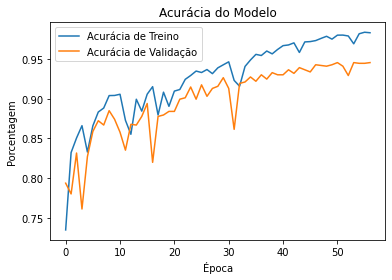

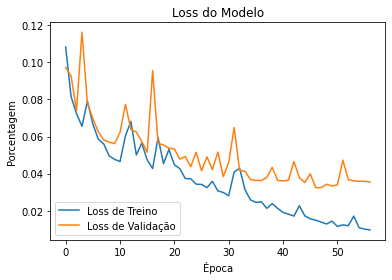

loss :  0.03547383472323418
accuracy :  0.9457013607025146


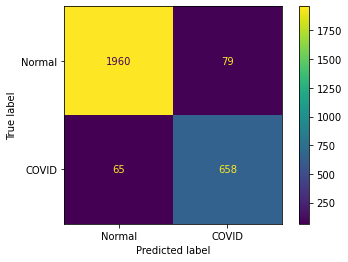

In [ ]:
show()

# LENET GRAYSCALE: COVID OR NORMAL WITH class_weights

In [ ]:
levels = ['Normal', 'COVID']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 28, 28)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 28, 28, 1)
(1105, 28, 28, 1)
(9941, 2)
(1105, 2)


In [ ]:
'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
'''
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)


In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
train_class_weight()

Epoch 1/2000
39/39 [==============================] - 1s 10ms/step - loss: 0.1093 - accuracy: 0.7351 - val_loss: 0.0924 - val_accuracy: 0.7439
Epoch 2/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0895 - accuracy: 0.7850 - val_loss: 0.0797 - val_accuracy: 0.8136
Epoch 3/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0803 - accuracy: 0.8224 - val_loss: 0.0854 - val_accuracy: 0.8127
Epoch 4/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 0.8404 - val_loss: 0.0690 - val_accuracy: 0.8480
Epoch 5/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0689 - accuracy: 0.8508 - val_loss: 0.0665 - val_accuracy: 0.8579
Epoch 6/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0662 - accuracy: 0.8643 - val_loss: 0.0712 - val_accuracy: 0.8326
Epoch 7/2000
39/39 [==============================] - 0s 5ms/step - loss: 0.0634 - accuracy: 0.8714 - val_loss: 0.0556 - val_accuracy: 0.8842
Epoch

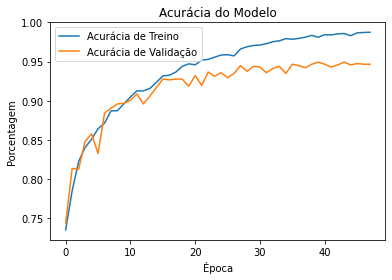

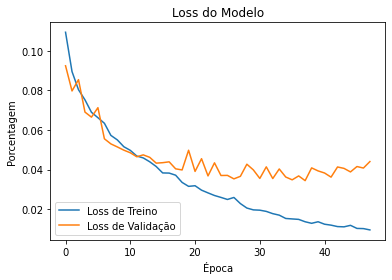

loss :  0.04406208544969559
accuracy :  0.9466063380241394


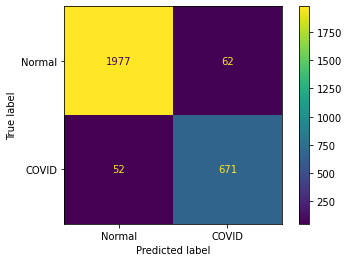

In [ ]:
show()

# LENET GRAYSCALE: COVID OR NORMAL WITH class_weights BALANCED

In [ ]:
levels = ['Normal', 'COVID']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 28, 28)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12545, 28, 28, 1)
(1105, 28, 28, 1)
(12545, 2)
(1105, 2)


In [ ]:
'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
'''
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)


In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_44 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_19 (Flatten)        (None, 9216)              0         
                                                                 
 dense_38 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
train_class_weight()

Epoch 1/2000
50/50 [==============================] - 1s 8ms/step - loss: 0.1284 - accuracy: 0.7399 - val_loss: 0.0961 - val_accuracy: 0.7891
Epoch 2/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0979 - accuracy: 0.8269 - val_loss: 0.1068 - val_accuracy: 0.7285
Epoch 3/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.1004 - accuracy: 0.8201 - val_loss: 0.0842 - val_accuracy: 0.8199
Epoch 4/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0839 - accuracy: 0.8585 - val_loss: 0.0734 - val_accuracy: 0.8489
Epoch 5/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0755 - accuracy: 0.8719 - val_loss: 0.1036 - val_accuracy: 0.7548
Epoch 6/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0874 - accuracy: 0.8399 - val_loss: 0.0684 - val_accuracy: 0.8570
Epoch 7/2000
50/50 [==============================] - 0s 5ms/step - loss: 0.0730 - accuracy: 0.8773 - val_loss: 0.0628 - val_accuracy: 0.8715
Epoch 

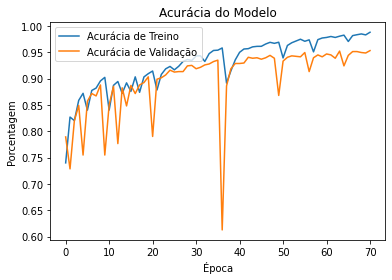

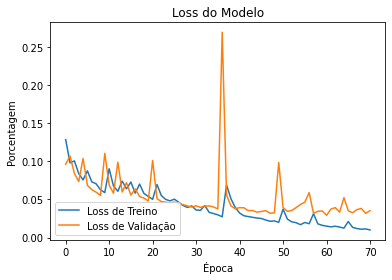

loss :  0.035137902945280075
accuracy :  0.9529411792755127


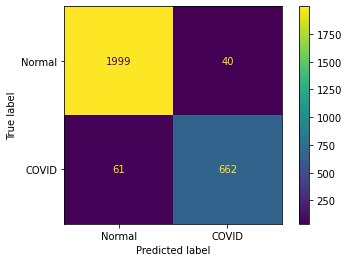

In [ ]:
show()

# LENET RGB: COVID OR NORMAL



In [ ]:
levels = ['Normal', 'COVID']
img_size = 28
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 28, 28, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 28, 28, 3)
(1105, 28, 28, 3)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, channels)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_23 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_11 (Flatten)        (None, 9216)              0         
                                                                 
 dense_22 (Dense)            (None, 128)               1179776   
                                                     

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 1s 11ms/step - loss: 0.1092 - accuracy: 0.7333 - val_loss: 0.0895 - val_accuracy: 0.8145
Epoch 2/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0855 - accuracy: 0.8136 - val_loss: 0.0756 - val_accuracy: 0.8434
Epoch 3/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0740 - accuracy: 0.8497 - val_loss: 0.0676 - val_accuracy: 0.8498
Epoch 4/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0682 - accuracy: 0.8577 - val_loss: 0.0612 - val_accuracy: 0.8697
Epoch 5/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0657 - accuracy: 0.8629 - val_loss: 0.0573 - val_accuracy: 0.8724
Epoch 6/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0592 - accuracy: 0.8759 - val_loss: 0.0545 - val_accuracy: 0.8724
Epoch 7/2000
39/39 [==============================] - 0s 6ms/step - loss: 0.0558 - accuracy: 0.8843 - val_loss: 0.0504 - val_accuracy: 0.8914
Epoch

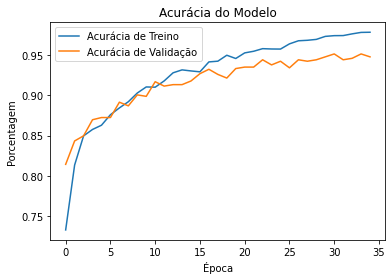

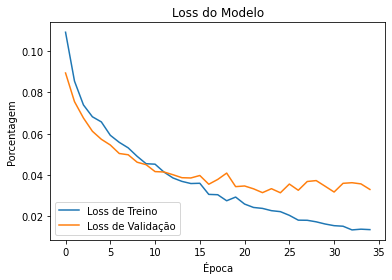

loss :  0.032971933484077454
accuracy :  0.9475113153457642


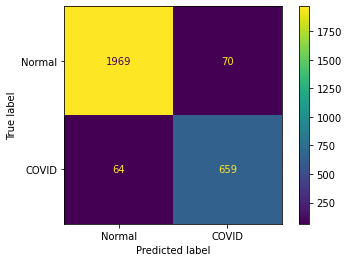

In [ ]:
show()

# SANA SHAIKH GRAYSCALE: COVID OR NORMAL

In [ ]:
levels = ['Normal', 'COVID']
img_size = 70
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 20
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 70, 70)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 70, 70, 1)
(1105, 70, 70, 1)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 16, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = n_classes))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 68, 68, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 34, 34, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 64)       

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 2s 30ms/step - loss: 1.0681 - accuracy: 0.6582 - val_loss: 0.8601 - val_accuracy: 0.7403
Epoch 2/2000
39/39 [==============================] - 1s 19ms/step - loss: 0.1657 - accuracy: 0.7020 - val_loss: 0.5453 - val_accuracy: 0.7385
Epoch 3/2000
39/39 [==============================] - 1s 18ms/step - loss: 0.1572 - accuracy: 0.7122 - val_loss: 0.3626 - val_accuracy: 0.7810
Epoch 4/2000
39/39 [==============================] - 1s 19ms/step - loss: 0.1463 - accuracy: 0.7369 - val_loss: 0.2312 - val_accuracy: 0.7882
Epoch 5/2000
39/39 [==============================] - 1s 19ms/step - loss: 0.1314 - accuracy: 0.7623 - val_loss: 0.2464 - val_accuracy: 0.7765
Epoch 6/2000
39/39 [==============================] - 1s 18ms/step - loss: 0.1930 - accuracy: 0.7206 - val_loss: 0.2760 - val_accuracy: 0.7376
Epoch 7/2000
39/39 [==============================] - 1s 19ms/step - loss: 0.1291 - accuracy: 0.7539 - val_loss: 0.1047 - val_accuracy: 0.8027

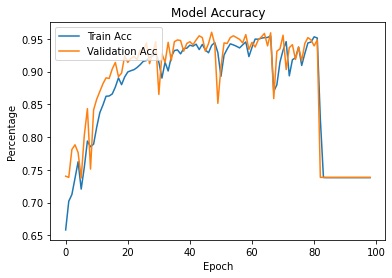

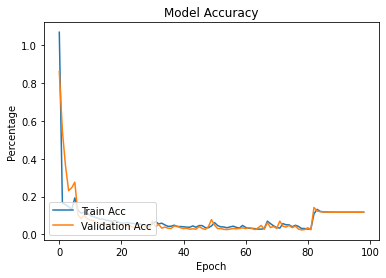

loss :  0.11726120114326477
accuracy :  0.7384615540504456


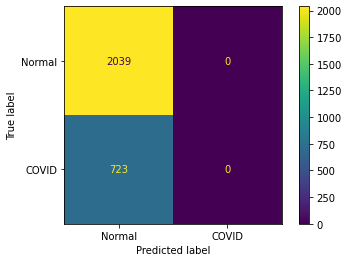

In [ ]:
show()

# SANA SHAIKH RGB: COVID OR NORMAL

In [ ]:
levels = ['Normal', 'COVID']
img_size = 70
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 20
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 70, 70, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 70, 70, 3)
(1105, 70, 70, 3)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 16, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = n_classes))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 34, 34, 128)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 64)      

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 12s 253ms/step - loss: 1.0715 - accuracy: 0.7248 - val_loss: 0.3788 - val_accuracy: 0.7385
Epoch 2/2000
39/39 [==============================] - 8s 204ms/step - loss: 0.4053 - accuracy: 0.7314 - val_loss: 0.3428 - val_accuracy: 0.7385
Epoch 3/2000
39/39 [==============================] - 8s 201ms/step - loss: 0.2054 - accuracy: 0.7156 - val_loss: 0.2519 - val_accuracy: 0.7385
Epoch 4/2000
39/39 [==============================] - 8s 206ms/step - loss: 0.1851 - accuracy: 0.7176 - val_loss: 0.2109 - val_accuracy: 0.7385
Epoch 5/2000
39/39 [==============================] - 6s 168ms/step - loss: 0.1730 - accuracy: 0.7209 - val_loss: 0.2021 - val_accuracy: 0.7385
Epoch 6/2000
39/39 [==============================] - 10s 257ms/step - loss: 0.1653 - accuracy: 0.7168 - val_loss: 0.2009 - val_accuracy: 0.7385
Epoch 7/2000
39/39 [==============================] - 9s 222ms/step - loss: 0.1594 - accuracy: 0.7208 - val_loss: 0.1883 - val_accurac

KeyboardInterrupt: ignored

In [ ]:
show()

# ALEXNET GRAYSCALE: COVID OR NORMAL

In [ ]:
levels = ['Normal', 'COVID']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 128, 128, 1)
(1105, 128, 128, 1)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 2s 37ms/step - loss: 0.0997 - accuracy: 0.7611 - val_loss: 0.0692 - val_accuracy: 0.8471
Epoch 2/2000
39/39 [==============================] - 1s 23ms/step - loss: 0.0679 - accuracy: 0.8557 - val_loss: 0.0568 - val_accuracy: 0.8878
Epoch 3/2000
39/39 [==============================] - 1s 23ms/step - loss: 0.0558 - accuracy: 0.8945 - val_loss: 0.0481 - val_accuracy: 0.9059
Epoch 4/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0468 - accuracy: 0.9121 - val_loss: 0.0417 - val_accuracy: 0.9222
Epoch 5/2000
39/39 [==============================] - 1s 23ms/step - loss: 0.0404 - accuracy: 0.9292 - val_loss: 0.0420 - val_accuracy: 0.9213
Epoch 6/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0340 - accuracy: 0.9411 - val_loss: 0.0324 - val_accuracy: 0.9394
Epoch 7/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0301 - accuracy: 0.9501 - val_loss: 0.0371 - val_accuracy: 0.9303

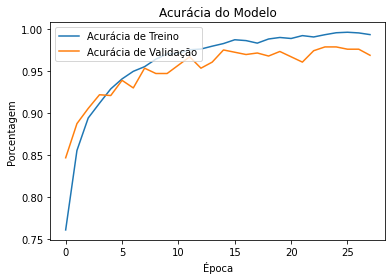

loss :  0.02436249703168869
accuracy :  0.9692307710647583


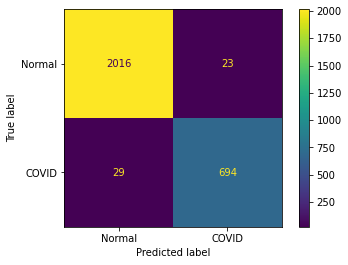

In [ ]:
show()

# ALEXNET RGB: COVID OR NORMAL

In [ ]:
levels = ['Normal', 'COVID']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 128, 128, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 128, 128, 3)
(1105, 128, 128, 3)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 3s 45ms/step - loss: 0.1250 - accuracy: 0.7349 - val_loss: 0.0810 - val_accuracy: 0.7973
Epoch 2/2000
39/39 [==============================] - 1s 34ms/step - loss: 0.0703 - accuracy: 0.8508 - val_loss: 0.0579 - val_accuracy: 0.8805
Epoch 3/2000
39/39 [==============================] - 1s 33ms/step - loss: 0.0565 - accuracy: 0.8895 - val_loss: 0.0521 - val_accuracy: 0.8805
Epoch 4/2000
39/39 [==============================] - 1s 33ms/step - loss: 0.0486 - accuracy: 0.9079 - val_loss: 0.0416 - val_accuracy: 0.9131
Epoch 5/2000
39/39 [==============================] - 1s 34ms/step - loss: 0.0424 - accuracy: 0.9198 - val_loss: 0.0382 - val_accuracy: 0.9249
Epoch 6/2000
39/39 [==============================] - 1s 32ms/step - loss: 0.0371 - accuracy: 0.9342 - val_loss: 0.0364 - val_accuracy: 0.9240
Epoch 7/2000
39/39 [==============================] - 1s 33ms/step - loss: 0.0336 - accuracy: 0.9412 - val_loss: 0.0322 - val_accuracy: 0.9339

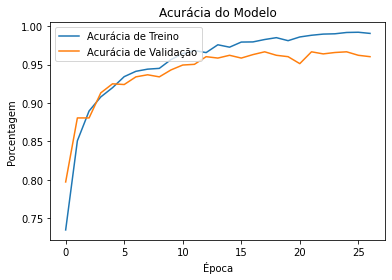

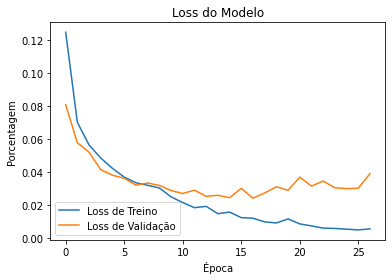

loss :  0.039196792989969254
accuracy :  0.9601809978485107


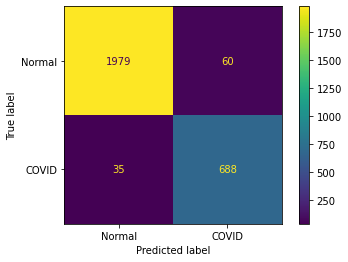

In [ ]:
show()

# ALEXNET GRAYSCALE: COVID OR NORMAL WITH class_weight



In [ ]:
levels = ['Normal', 'COVID']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 128, 128, 1)
(1105, 128, 128, 1)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
39/39 [==============================] - 2s 29ms/step - loss: 0.1091 - accuracy: 0.7350 - val_loss: 0.0773 - val_accuracy: 0.8027
Epoch 2/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0709 - accuracy: 0.8471 - val_loss: 0.0595 - val_accuracy: 0.8715
Epoch 3/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0597 - accuracy: 0.8825 - val_loss: 0.0526 - val_accuracy: 0.9050
Epoch 4/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0521 - accuracy: 0.8993 - val_loss: 0.0469 - val_accuracy: 0.9113
Epoch 5/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0457 - accuracy: 0.9148 - val_loss: 0.0406 - val_accuracy: 0.9249
Epoch 6/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0399 - accuracy: 0.9272 - val_loss: 0.0364 - val_accuracy: 0.9312
Epoch 7/2000
39/39 [==============================] - 1s 24ms/step - loss: 0.0346 - accuracy: 0.9413 - val_loss: 0.0322 - val_accuracy: 0.9403

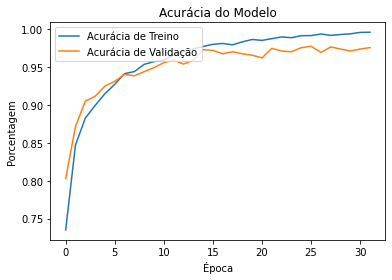

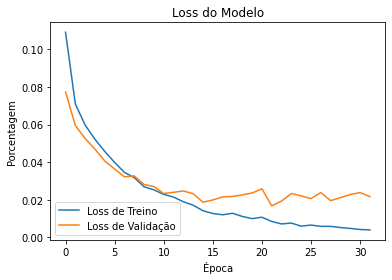

loss :  0.021686943247914314
accuracy :  0.9755656123161316


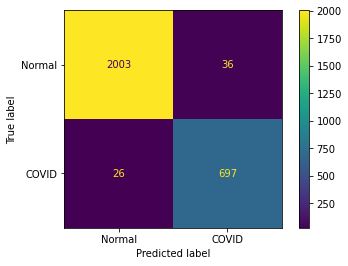

In [ ]:
show()

# ALEXNET GRAYSCALE: COVID OR NORMAL BALANCED



In [ ]:
levels = ['Normal', 'COVID']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12545, 128, 128, 1)
(1105, 128, 128, 1)
(12545, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
50/50 [==============================] - 2s 27ms/step - loss: 0.1170 - accuracy: 0.6969 - val_loss: 0.0992 - val_accuracy: 0.7765
Epoch 2/2000
50/50 [==============================] - 1s 22ms/step - loss: 0.0825 - accuracy: 0.8218 - val_loss: 0.0679 - val_accuracy: 0.8615
Epoch 3/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0576 - accuracy: 0.8900 - val_loss: 0.0560 - val_accuracy: 0.8733
Epoch 4/2000
50/50 [==============================] - 1s 22ms/step - loss: 0.0462 - accuracy: 0.9146 - val_loss: 0.0504 - val_accuracy: 0.8968
Epoch 5/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0408 - accuracy: 0.9259 - val_loss: 0.0425 - val_accuracy: 0.9222
Epoch 6/2000
50/50 [==============================] - 1s 22ms/step - loss: 0.0330 - accuracy: 0.9416 - val_loss: 0.0370 - val_accuracy: 0.9357
Epoch 7/2000
50/50 [==============================] - 1s 22ms/step - loss: 0.0283 - accuracy: 0.9520 - val_loss: 0.0369 - val_accuracy: 0.9176

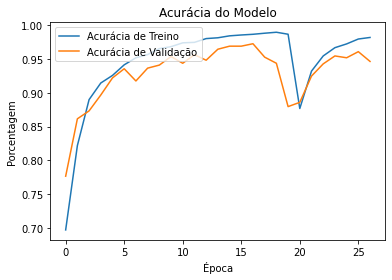

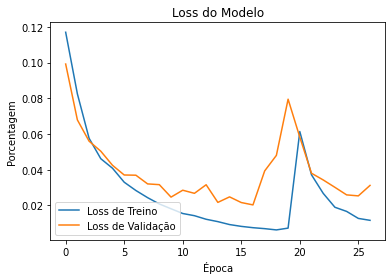

loss :  0.03118666261434555
accuracy :  0.9466063380241394


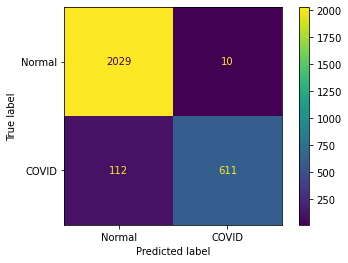

In [ ]:
show()

# ALEXNET GRAYSCALE: COVID OR NORMAL BALANCED class_weight



In [ ]:
levels = ['Normal', 'COVID']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12545, 128, 128, 1)
(1105, 128, 128, 1)
(12545, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation="softmax"))

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
50/50 [==============================] - 2s 27ms/step - loss: 0.1148 - accuracy: 0.7686 - val_loss: 0.0648 - val_accuracy: 0.8588
Epoch 2/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0665 - accuracy: 0.8962 - val_loss: 0.0598 - val_accuracy: 0.8805
Epoch 3/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0512 - accuracy: 0.9230 - val_loss: 0.0494 - val_accuracy: 0.9086
Epoch 4/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0429 - accuracy: 0.9358 - val_loss: 0.0422 - val_accuracy: 0.9195
Epoch 5/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0353 - accuracy: 0.9479 - val_loss: 0.0395 - val_accuracy: 0.9376
Epoch 6/2000
50/50 [==============================] - 1s 23ms/step - loss: 0.0314 - accuracy: 0.9536 - val_loss: 0.0330 - val_accuracy: 0.9502
Epoch 7/2000
50/50 [==============================] - 1s 24ms/step - loss: 0.0256 - accuracy: 0.9625 - val_loss: 0.0445 - val_accuracy: 0.9222

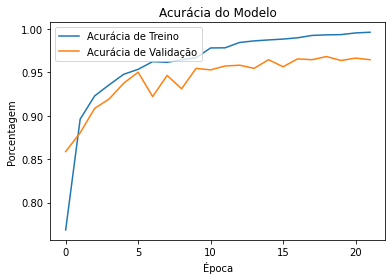

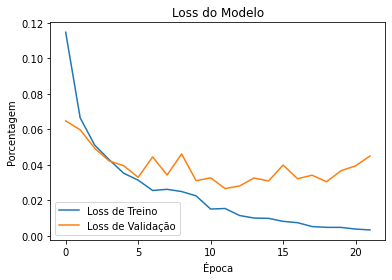

loss :  0.04503854736685753
accuracy :  0.9647058844566345


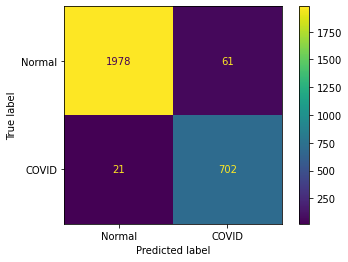

In [ ]:
show()

# ALEXNET GRAYSCALE: 3 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(15153, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10909, 128, 128, 1)
(1213, 128, 128, 1)
(10909, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
43/43 [==============================] - 2s 43ms/step - loss: 0.0837 - accuracy: 0.7195 - val_loss: 0.0558 - val_accuracy: 0.8335
Epoch 2/2000
43/43 [==============================] - 1s 23ms/step - loss: 0.0504 - accuracy: 0.8551 - val_loss: 0.0417 - val_accuracy: 0.8821
Epoch 3/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0405 - accuracy: 0.8895 - val_loss: 0.0348 - val_accuracy: 0.9044
Epoch 4/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0334 - accuracy: 0.9133 - val_loss: 0.0357 - val_accuracy: 0.8994
Epoch 5/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0295 - accuracy: 0.9237 - val_loss: 0.0274 - val_accuracy: 0.9283
Epoch 6/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0243 - accuracy: 0.9402 - val_loss: 0.0250 - val_accuracy: 0.9365
Epoch 7/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0215 - accuracy: 0.9469 - val_loss: 0.0222 - val_accuracy: 0.9464

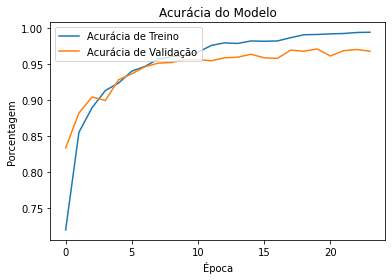

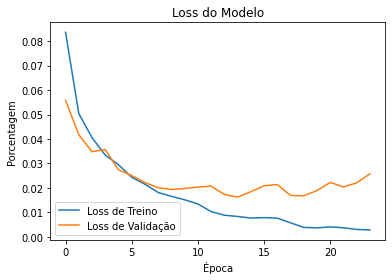

loss :  0.025745995342731476
accuracy :  0.9678483009338379


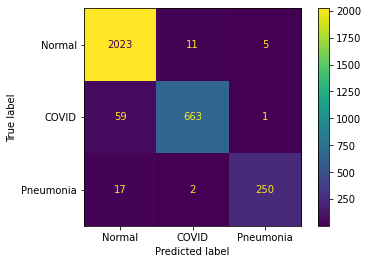

In [ ]:
show()

# ALEXNET GRAYSCALE: 3 CATEGORIES WITH class_weight

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(15153, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10909, 128, 128, 1)
(1213, 128, 128, 1)
(10909, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
43/43 [==============================] - 2s 28ms/step - loss: 0.0809 - accuracy: 0.7273 - val_loss: 0.0535 - val_accuracy: 0.8384
Epoch 2/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0482 - accuracy: 0.8652 - val_loss: 0.0396 - val_accuracy: 0.8862
Epoch 3/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0377 - accuracy: 0.8981 - val_loss: 0.0341 - val_accuracy: 0.9035
Epoch 4/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0342 - accuracy: 0.9079 - val_loss: 0.0301 - val_accuracy: 0.9101
Epoch 5/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0262 - accuracy: 0.9344 - val_loss: 0.0267 - val_accuracy: 0.9316
Epoch 6/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0231 - accuracy: 0.9416 - val_loss: 0.0236 - val_accuracy: 0.9390
Epoch 7/2000
43/43 [==============================] - 1s 24ms/step - loss: 0.0207 - accuracy: 0.9452 - val_loss: 0.0219 - val_accuracy: 0.9431

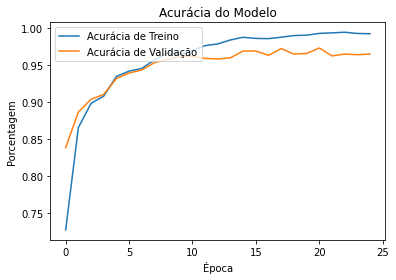

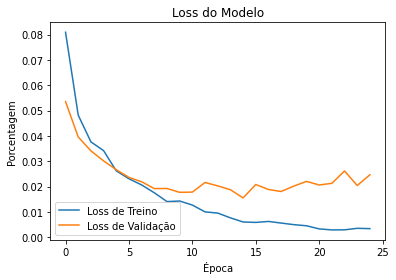

loss :  0.02465517446398735
accuracy :  0.9645506739616394


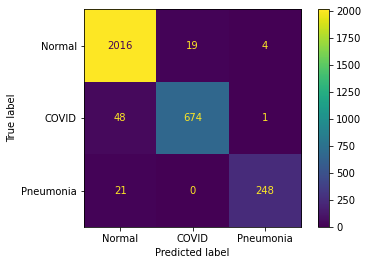

In [ ]:
show()

# ALEXNET GRAYSCALE: 3 BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(15153, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(19321, 128, 128, 1)
(1213, 128, 128, 1)
(19321, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
76/76 [==============================] - 3s 28ms/step - loss: 0.0624 - accuracy: 0.8027 - val_loss: 0.0479 - val_accuracy: 0.8689
Epoch 2/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0360 - accuracy: 0.9044 - val_loss: 0.0375 - val_accuracy: 0.8961
Epoch 3/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0290 - accuracy: 0.9268 - val_loss: 0.0302 - val_accuracy: 0.9126
Epoch 4/2000
76/76 [==============================] - 2s 22ms/step - loss: 0.0247 - accuracy: 0.9411 - val_loss: 0.0272 - val_accuracy: 0.9176
Epoch 5/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0205 - accuracy: 0.9506 - val_loss: 0.0248 - val_accuracy: 0.9266
Epoch 6/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0172 - accuracy: 0.9584 - val_loss: 0.0246 - val_accuracy: 0.9382
Epoch 7/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0147 - accuracy: 0.9641 - val_loss: 0.0220 - val_accuracy: 0.9390

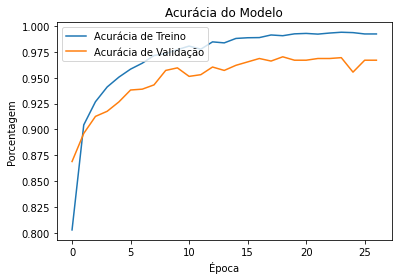

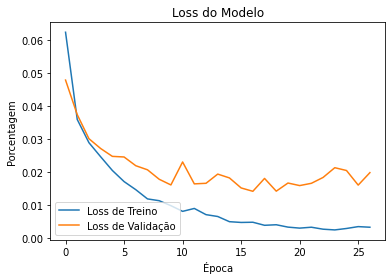

loss :  0.019896840676665306
accuracy :  0.9670239090919495


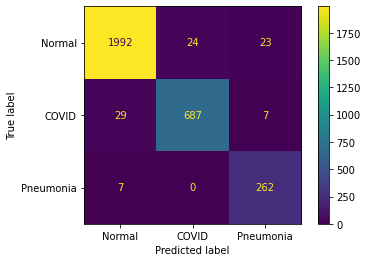

In [ ]:
show()

# ALEXNET GRAYSCALE: 3 BALANCED class_weight

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(15153, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(19321, 128, 128, 1)
(1213, 128, 128, 1)
(19321, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
76/76 [==============================] - 3s 26ms/step - loss: 0.1248 - accuracy: 0.7924 - val_loss: 0.0555 - val_accuracy: 0.8302
Epoch 2/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0698 - accuracy: 0.9020 - val_loss: 0.0390 - val_accuracy: 0.8961
Epoch 3/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0535 - accuracy: 0.9291 - val_loss: 0.0355 - val_accuracy: 0.9126
Epoch 4/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0427 - accuracy: 0.9446 - val_loss: 0.0254 - val_accuracy: 0.9365
Epoch 5/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0353 - accuracy: 0.9563 - val_loss: 0.0259 - val_accuracy: 0.9382
Epoch 6/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0298 - accuracy: 0.9633 - val_loss: 0.0217 - val_accuracy: 0.9448
Epoch 7/2000
76/76 [==============================] - 2s 23ms/step - loss: 0.0262 - accuracy: 0.9674 - val_loss: 0.0198 - val_accuracy: 0.9538

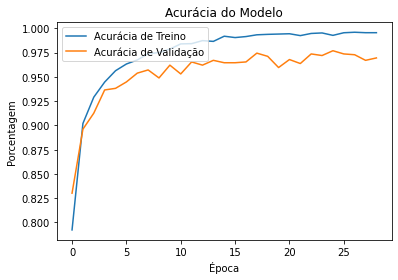

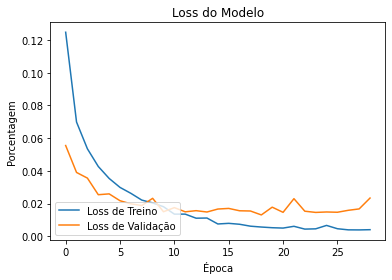

loss :  0.023343956097960472
accuracy :  0.9694971442222595


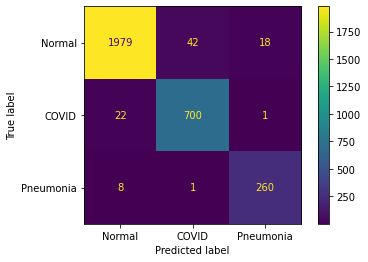

In [ ]:
show()

# ALEXNET GRAYSCALE: 4 CATEGORIES

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 128, 128, 1)
(1694, 128, 128, 1)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
60/60 [==============================] - 3s 31ms/step - loss: 0.0890 - accuracy: 0.5833 - val_loss: 0.0647 - val_accuracy: 0.7255
Epoch 2/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0637 - accuracy: 0.7454 - val_loss: 0.0533 - val_accuracy: 0.7792
Epoch 3/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0553 - accuracy: 0.7874 - val_loss: 0.0471 - val_accuracy: 0.8205
Epoch 4/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0484 - accuracy: 0.8206 - val_loss: 0.0420 - val_accuracy: 0.8501
Epoch 5/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0441 - accuracy: 0.8355 - val_loss: 0.0426 - val_accuracy: 0.8453
Epoch 6/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0413 - accuracy: 0.8496 - val_loss: 0.0407 - val_accuracy: 0.8453
Epoch 7/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0364 - accuracy: 0.8706 - val_loss: 0.0351 - val_accuracy: 0.8725

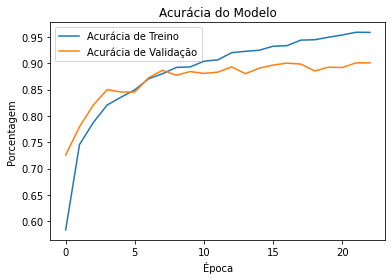

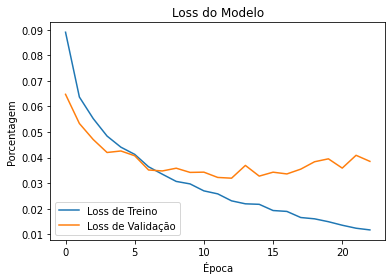

loss :  0.03852180764079094
accuracy :  0.9008264541625977


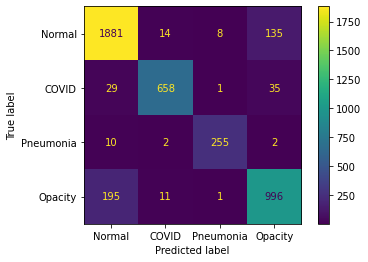

In [ ]:
show()

# ALEXNET GRAYSCALE: 4 CATEGORIES WITH class_weight

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 128, 128)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15238, 128, 128, 1)
(1694, 128, 128, 1)
(15238, 4)
(1694, 4)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
60/60 [==============================] - 2s 28ms/step - loss: 0.0863 - accuracy: 0.5971 - val_loss: 0.0614 - val_accuracy: 0.7420
Epoch 2/2000
60/60 [==============================] - 1s 24ms/step - loss: 0.0619 - accuracy: 0.7529 - val_loss: 0.0551 - val_accuracy: 0.7839
Epoch 3/2000
60/60 [==============================] - 1s 24ms/step - loss: 0.0528 - accuracy: 0.8021 - val_loss: 0.0466 - val_accuracy: 0.8241
Epoch 4/2000
60/60 [==============================] - 1s 24ms/step - loss: 0.0471 - accuracy: 0.8258 - val_loss: 0.0427 - val_accuracy: 0.8412
Epoch 5/2000
60/60 [==============================] - 1s 24ms/step - loss: 0.0425 - accuracy: 0.8443 - val_loss: 0.0383 - val_accuracy: 0.8595
Epoch 6/2000
60/60 [==============================] - 1s 24ms/step - loss: 0.0392 - accuracy: 0.8577 - val_loss: 0.0376 - val_accuracy: 0.8613
Epoch 7/2000
60/60 [==============================] - 1s 23ms/step - loss: 0.0355 - accuracy: 0.8714 - val_loss: 0.0359 - val_accuracy: 0.8666

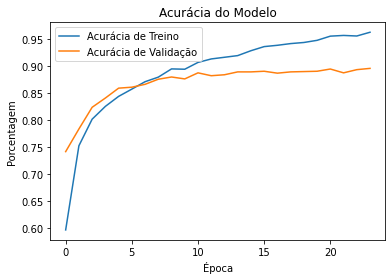

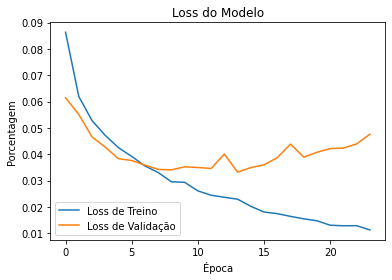

loss :  0.04761398211121559
accuracy :  0.8961039185523987


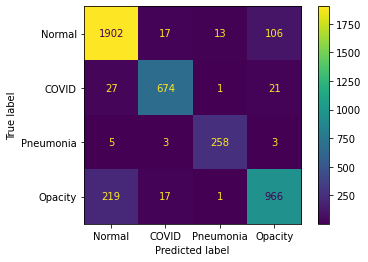

In [ ]:
show()

# ALEXNET GRAYSCALE: 4 CATEGORIES BALANCED

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(23650, 128, 128, 1)
(1694, 128, 128, 1)
(23650, 4)
(1694, 4)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train()

Epoch 1/2000
93/93 [==============================] - 3s 27ms/step - loss: 0.0691 - accuracy: 0.7064 - val_loss: 0.0587 - val_accuracy: 0.7580
Epoch 2/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0435 - accuracy: 0.8378 - val_loss: 0.0499 - val_accuracy: 0.8188
Epoch 3/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0368 - accuracy: 0.8682 - val_loss: 0.0448 - val_accuracy: 0.8312
Epoch 4/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0318 - accuracy: 0.8879 - val_loss: 0.0420 - val_accuracy: 0.8483
Epoch 5/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0284 - accuracy: 0.8973 - val_loss: 0.0371 - val_accuracy: 0.8636
Epoch 6/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0255 - accuracy: 0.9099 - val_loss: 0.0364 - val_accuracy: 0.8595
Epoch 7/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0233 - accuracy: 0.9174 - val_loss: 0.0337 - val_accuracy: 0.8802

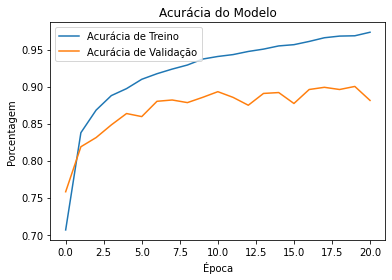

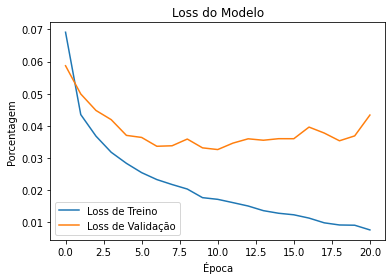

loss :  0.04337989166378975
accuracy :  0.8813459277153015


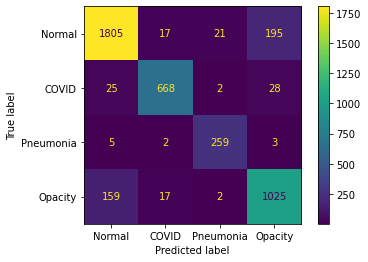

In [ ]:
show()

# ALEXNET GRAYSCALE: 4 CATEGORIES BALANCED class_weight

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 128
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(21165, 128, 128)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(23650, 128, 128, 1)
(1694, 128, 128, 1)
(23650, 4)
(1694, 4)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, channels)))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 16, 16, 64)     

In [ ]:
train_class_weight()

Epoch 1/2000
93/93 [==============================] - 3s 25ms/step - loss: 0.1374 - accuracy: 0.6628 - val_loss: 0.0648 - val_accuracy: 0.7113
Epoch 2/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0875 - accuracy: 0.8112 - val_loss: 0.0567 - val_accuracy: 0.7698
Epoch 3/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0734 - accuracy: 0.8479 - val_loss: 0.0485 - val_accuracy: 0.8158
Epoch 4/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0662 - accuracy: 0.8662 - val_loss: 0.0461 - val_accuracy: 0.8205
Epoch 5/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0579 - accuracy: 0.8821 - val_loss: 0.0405 - val_accuracy: 0.8489
Epoch 6/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0546 - accuracy: 0.8906 - val_loss: 0.0384 - val_accuracy: 0.8566
Epoch 7/2000
93/93 [==============================] - 2s 23ms/step - loss: 0.0501 - accuracy: 0.8987 - val_loss: 0.0398 - val_accuracy: 0.8595

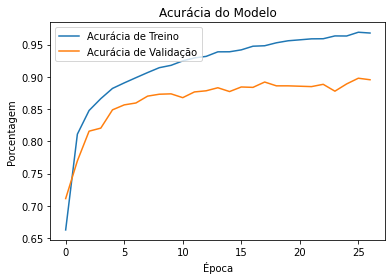

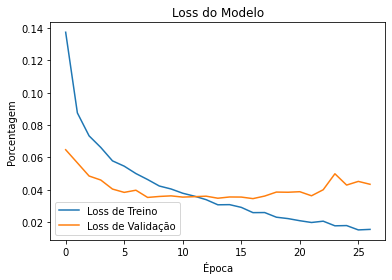

loss :  0.04343410208821297
accuracy :  0.8955135941505432


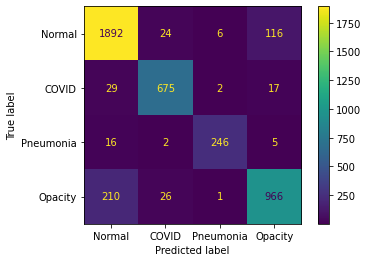

In [ ]:
show()

# VGGNET GRAYSCALE: COVID OR NORMAL

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224)


In [ ]:

format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(9941, 224, 224, 1)
(1105, 224, 224, 1)
(9941, 2)
(1105, 2)


In [ ]:
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(img_size, img_size, channels)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 222, 222, 64)      640       
                                                                 
 conv2d_91 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_92 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_93 (Conv2D)          (None, 106, 106, 128)   

In [ ]:
train()
#train_v2()

Epoch 1/2000
39/39 [==============================] - 41s 849ms/step - loss: 0.2873 - accuracy: 0.7558 - val_loss: 0.3250 - val_accuracy: 0.7376
Epoch 2/2000
39/39 [==============================] - 18s 459ms/step - loss: 0.0836 - accuracy: 0.8127 - val_loss: 0.2553 - val_accuracy: 0.2615
Epoch 3/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0758 - accuracy: 0.8356 - val_loss: 0.3536 - val_accuracy: 0.2615
Epoch 4/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0695 - accuracy: 0.8549 - val_loss: 0.3097 - val_accuracy: 0.2615
Epoch 5/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0622 - accuracy: 0.8697 - val_loss: 0.4368 - val_accuracy: 0.2615
Epoch 6/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0600 - accuracy: 0.8863 - val_loss: 0.3233 - val_accuracy: 0.2615
Epoch 7/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0556 - accuracy: 0.8908 - val_loss: 0.5122 - val_ac

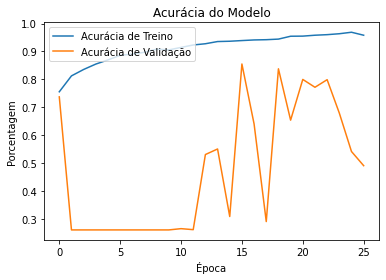

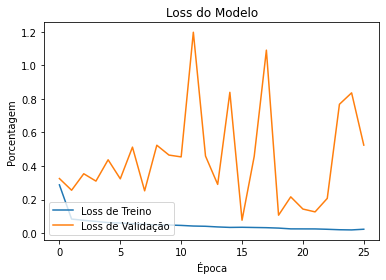

loss :  0.5241109132766724
accuracy :  0.4914027154445648


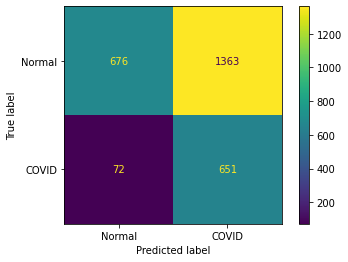

In [ ]:
show()

# VGGNET GRAYSCALE: COVID OR NORMAL class_weight

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224)


In [ ]:

format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(9941, 224, 224, 1)
(1105, 224, 224, 1)
(9941, 2)
(1105, 2)


In [ ]:
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(img_size, img_size, channels)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 222, 222, 64)      640       
                                                                 
 conv2d_104 (Conv2D)         (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_105 (Conv2D)         (None, 108, 108, 128)     73856     
                                                                 
 conv2d_106 (Conv2D)         (None, 106, 106, 128)   

In [ ]:
train_class_weight()
#train_v2()

Epoch 1/2000
39/39 [==============================] - 20s 468ms/step - loss: 0.2163 - accuracy: 0.7483 - val_loss: 0.2908 - val_accuracy: 0.7385
Epoch 2/2000
39/39 [==============================] - 18s 459ms/step - loss: 0.0824 - accuracy: 0.8168 - val_loss: 0.2299 - val_accuracy: 0.2606
Epoch 3/2000
39/39 [==============================] - 18s 459ms/step - loss: 0.0754 - accuracy: 0.8414 - val_loss: 0.1328 - val_accuracy: 0.6679
Epoch 4/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0710 - accuracy: 0.8471 - val_loss: 0.4390 - val_accuracy: 0.2633
Epoch 5/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0657 - accuracy: 0.8655 - val_loss: 0.6040 - val_accuracy: 0.2624
Epoch 6/2000
39/39 [==============================] - 18s 458ms/step - loss: 0.0622 - accuracy: 0.8748 - val_loss: 0.1627 - val_accuracy: 0.3529
Epoch 7/2000
39/39 [==============================] - 18s 459ms/step - loss: 0.0610 - accuracy: 0.8833 - val_loss: 0.2906 - val_ac

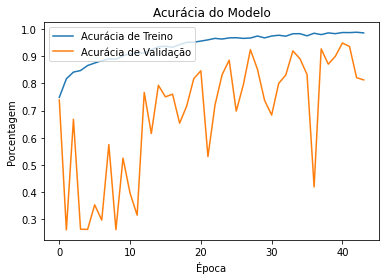

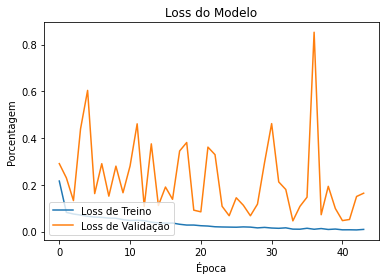

loss :  0.16432321071624756
accuracy :  0.8126696944236755


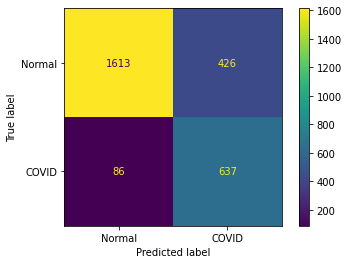

In [ ]:
show()

# VGGNET GRAYSCALE: COVID OR NORMAL BALANCED

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224)


In [ ]:

format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(12545, 224, 224, 1)
(1105, 224, 224, 1)
(12545, 2)
(1105, 2)


In [ ]:
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(img_size, img_size, channels)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)    

In [ ]:
train()
#train_v2()

Epoch 1/2000
50/50 [==============================] - 37s 351ms/step - loss: 0.2336 - accuracy: 0.6958 - val_loss: nan - val_accuracy: 0.7385
Epoch 2/2000
50/50 [==============================] - 15s 305ms/step - loss: 0.0936 - accuracy: 0.7759 - val_loss: nan - val_accuracy: 0.7385
Epoch 3/2000
50/50 [==============================] - 15s 304ms/step - loss: 0.0825 - accuracy: 0.8101 - val_loss: nan - val_accuracy: 0.7385
Epoch 4/2000
50/50 [==============================] - 15s 305ms/step - loss: 0.0722 - accuracy: 0.8385 - val_loss: nan - val_accuracy: 0.7385
Epoch 5/2000
50/50 [==============================] - 15s 304ms/step - loss: 0.0686 - accuracy: 0.8469 - val_loss: nan - val_accuracy: 0.7385
Epoch 6/2000
50/50 [==============================] - 15s 305ms/step - loss: 0.0610 - accuracy: 0.8666 - val_loss: nan - val_accuracy: 0.7385
Epoch 7/2000
50/50 [==============================] - 15s 305ms/step - loss: 0.0564 - accuracy: 0.8822 - val_loss: nan - val_accuracy: 0.7385
Epoch 

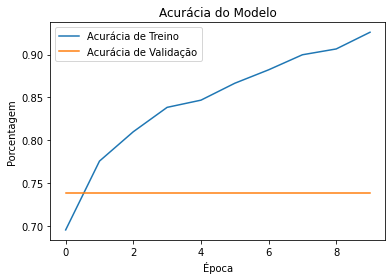

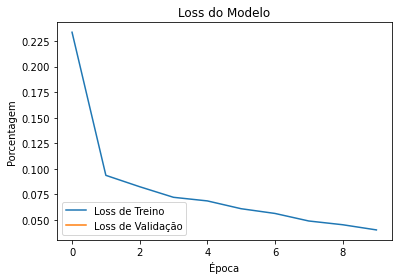

loss :  nan
accuracy :  0.7384615540504456


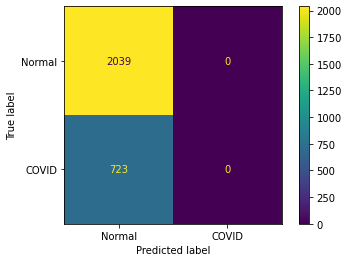

In [ ]:
show()

# VGGNET GRAYSCALE: COVID OR NORMAL BALANCED class_weight

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224)


In [ ]:

format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(12545, 224, 224, 1)
(1105, 224, 224, 1)
(12545, 2)
(1105, 2)


In [ ]:
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_size,
                                  img_size,
                                  channels)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
model = models.Sequential()

#model.add(data_augmentation)

model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(img_size, img_size, channels)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 128)    

In [ ]:
train_class_weight()
#train_v2()

Epoch 1/2000
50/50 [==============================] - 24s 455ms/step - loss: 0.2569 - accuracy: 0.7166 - val_loss: nan - val_accuracy: 0.7385
Epoch 2/2000
50/50 [==============================] - 22s 448ms/step - loss: 0.0949 - accuracy: 0.8231 - val_loss: nan - val_accuracy: 0.7385
Epoch 3/2000
50/50 [==============================] - 22s 448ms/step - loss: 0.0818 - accuracy: 0.8583 - val_loss: nan - val_accuracy: 0.7385
Epoch 4/2000
50/50 [==============================] - 22s 448ms/step - loss: 0.0727 - accuracy: 0.8788 - val_loss: nan - val_accuracy: 0.7385
Epoch 5/2000
50/50 [==============================] - 22s 448ms/step - loss: 0.0671 - accuracy: 0.8882 - val_loss: nan - val_accuracy: 0.7385
Epoch 6/2000
50/50 [==============================] - 22s 447ms/step - loss: 0.0640 - accuracy: 0.8937 - val_loss: nan - val_accuracy: 0.7385
Epoch 7/2000
50/50 [==============================] - 22s 447ms/step - loss: 0.0632 - accuracy: 0.8945 - val_loss: nan - val_accuracy: 0.7385
Epoch 

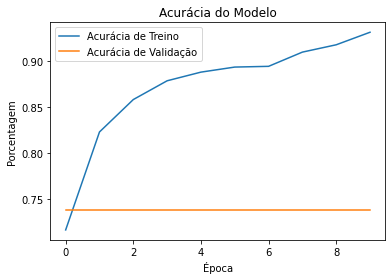

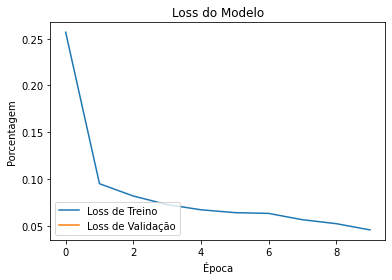

loss :  nan
accuracy :  0.7384615540504456


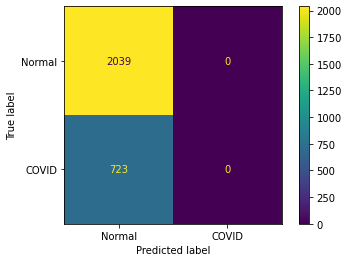

In [ ]:
show()

# VGG19 - transfer learning

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 224, 224, 3)
(1105, 224, 224, 3)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 9s 199ms/step - loss: 0.9191 - accuracy: 0.7992 - val_loss: 0.0644 - val_accuracy: 0.9095
Epoch 2/2000
39/39 [==============================] - 7s 170ms/step - loss: 0.0385 - accuracy: 0.9371 - val_loss: 0.0360 - val_accuracy: 0.9394
Epoch 3/2000
39/39 [==============================] - 7s 169ms/step - loss: 0.0280 - accuracy: 0.9529 - val_loss: 0.0317 - val_accuracy: 0.9466
Epoch 4/2000
39/39 [==============================] - 7s 169ms/step - loss: 0.0205 - accuracy: 0.9669 - val_loss: 0.0274 - val_accuracy: 0.9538
Epoch 5/2000
39/39 [==============================] - 7s 169ms/step - loss: 0.0288 - accuracy: 0.9480 - val_loss: 0.0266 - val_accuracy: 0.9548
Epoch 6/2000
39/39 [==============================] - 7s 171ms/step - loss: 0.0158 - accuracy: 0.9736 - val_loss: 0.0217 - val_accuracy: 0.9647
Epoch 7/2000
39/39 [==============================] - 7s 172ms/step - loss: 0.0104 - accuracy: 0.9844 - val_loss: 0.0233 - val_accuracy:

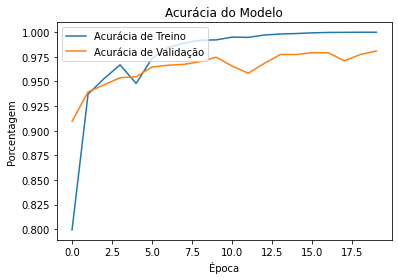

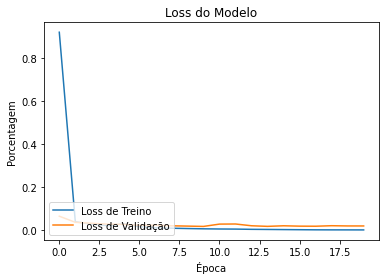

loss :  0.019035864621400833
accuracy :  0.9809954762458801


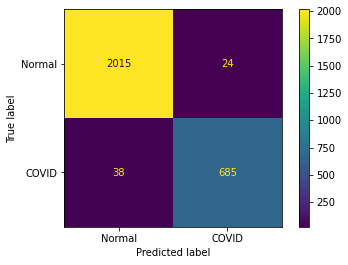

In [ ]:
show()

## 3 Classes

In [ ]:
levels = ['Normal', 'COVID','Viral Pneumonia']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(15153, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10909, 224, 224, 3)
(1213, 224, 224, 3)
(10909, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
train()

Epoch 1/2000
43/43 [==============================] - 23s 277ms/step - loss: 0.5128 - accuracy: 0.7464 - val_loss: 0.0389 - val_accuracy: 0.9110
Epoch 2/2000
43/43 [==============================] - 7s 169ms/step - loss: 0.0302 - accuracy: 0.9268 - val_loss: 0.0222 - val_accuracy: 0.9563
Epoch 3/2000
43/43 [==============================] - 7s 168ms/step - loss: 0.0209 - accuracy: 0.9512 - val_loss: 0.0186 - val_accuracy: 0.9571
Epoch 4/2000
43/43 [==============================] - 7s 170ms/step - loss: 0.0203 - accuracy: 0.9488 - val_loss: 0.0340 - val_accuracy: 0.9085
Epoch 5/2000
43/43 [==============================] - 7s 170ms/step - loss: 0.0145 - accuracy: 0.9662 - val_loss: 0.0143 - val_accuracy: 0.9629
Epoch 6/2000
43/43 [==============================] - 7s 168ms/step - loss: 0.0100 - accuracy: 0.9778 - val_loss: 0.0180 - val_accuracy: 0.9530
Epoch 7/2000
43/43 [==============================] - 7s 168ms/step - loss: 0.0116 - accuracy: 0.9711 - val_loss: 0.0197 - val_accuracy

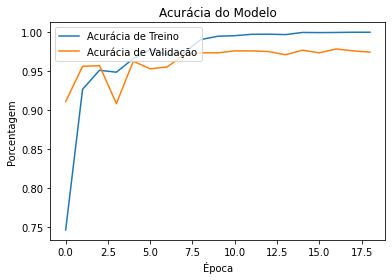

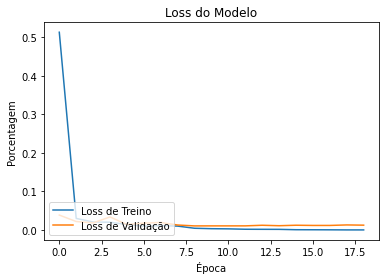

loss :  0.012735706754028797
accuracy :  0.9744435548782349


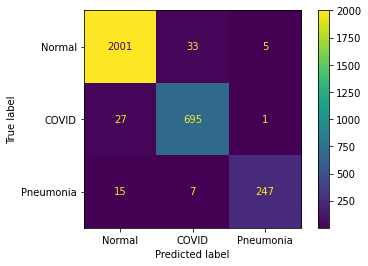

In [ ]:
show()

# Teste

In [ ]:
levels = ['Normal', 'COVID']
img_size = 70
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.0001
learning_patience = 5
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 70, 70)


In [ ]:

format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(9941, 70, 70, 1)
(1105, 70, 70, 1)
(9941, 2)
(1105, 2)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (img_size, img_size, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 16, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = n_classes))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 68, 68, 128)       1280      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 34, 34, 128)       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 16, 16, 64)      

In [ ]:
train()
#train_v2()

Epoch 1/2000
39/39 [==============================] - 3s 53ms/step - loss: 0.6007 - accuracy: 0.7244 - val_loss: 0.5424 - val_accuracy: 0.7638
Epoch 2/2000
39/39 [==============================] - 3s 90ms/step - loss: 0.5769 - accuracy: 0.7330 - val_loss: 0.5191 - val_accuracy: 0.7638
Epoch 3/2000
39/39 [==============================] - 2s 49ms/step - loss: 0.5557 - accuracy: 0.7318 - val_loss: 0.5556 - val_accuracy: 0.7638
Epoch 4/2000
39/39 [==============================] - 1s 19ms/step - loss: 0.5676 - accuracy: 0.7328 - val_loss: 0.4783 - val_accuracy: 0.7638
Epoch 5/2000
39/39 [==============================] - 1s 33ms/step - loss: 0.5544 - accuracy: 0.7325 - val_loss: 0.5313 - val_accuracy: 0.7638
Epoch 6/2000
39/39 [==============================] - 2s 47ms/step - loss: 0.5409 - accuracy: 0.7325 - val_loss: 0.4859 - val_accuracy: 0.7638
Epoch 7/2000
39/39 [==============================] - 1s 33ms/step - loss: 0.5403 - accuracy: 0.7342 - val_loss: 0.5060 - val_accuracy: 0.7638

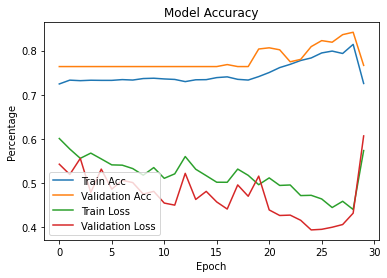

In [ ]:
show()

# TESTE

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 1
learning_rate = 0.0001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

Found 13808 files belonging to 2 classes.
Using 11047 files for training.
Found 13808 files belonging to 2 classes.
Using 2761 files for validation.
(256, 224, 224, 1)


In [ ]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
'''
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_dataset = prepare(train_dataset)
val_dataset = prepare(val_dataset)
'''

In [ ]:

format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(9941, 224, 224, 1)
(1105, 224, 224, 1)
(9941, 2)
(1105, 2)


In [ ]:
model = tf.keras.applications.densenet.DenseNet201(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(img_size, img_size, channels),
    pooling=None,
    classes=n_classes,
    classifier_activation='softmax'
)

model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
train()
#train_v2()

Epoch 1/2000


ResourceExhaustedError: ignored

In [ ]:
show()

# RESNET-50 - Transfer Learning

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 20
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(9941, 224, 224, 3)
(1105, 224, 224, 3)
(9941, 2)
(1105, 2)


In [ ]:
# Create an input layer with the shape of the input data
input_tensor = Input(shape=(img_size, img_size, channels))

# Instantiate the ResNet-50 model with pre-trained weights
model = models.Sequential()
#model.add(ResNet50(weights='imagenet', input_tensor=input_tensor, include_top=True))
model.add(ResNet50(weights='imagenet', input_tensor=input_tensor, include_top=False))
#model.trainable = False
model.add(keras.layers.Flatten())
model.add(layers.Dense(n_classes,activation = 'softmax'))
model.layers[0].trainable = False

# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = learning_patience)
history = model.fit(x_train, y_train, 
                          epochs = epochs, batch_size = batch_size,  
                          validation_data = (x_val, y_val),
                          callbacks = [es])

Epoch 1/2000
39/39 [==============================] - 20s 226ms/step - loss: 1.0700 - accuracy: 0.7377 - val_loss: 0.5589 - val_accuracy: 0.7131
Epoch 2/2000
39/39 [==============================] - 6s 150ms/step - loss: 0.4967 - accuracy: 0.7524 - val_loss: 0.5684 - val_accuracy: 0.7412
Epoch 3/2000
39/39 [==============================] - 6s 151ms/step - loss: 0.4706 - accuracy: 0.7583 - val_loss: 0.4520 - val_accuracy: 0.7674
Epoch 4/2000
39/39 [==============================] - 6s 150ms/step - loss: 0.4427 - accuracy: 0.7754 - val_loss: 0.4460 - val_accuracy: 0.7548
Epoch 5/2000
39/39 [==============================] - 6s 150ms/step - loss: 0.4324 - accuracy: 0.7806 - val_loss: 0.4409 - val_accuracy: 0.7774
Epoch 6/2000
39/39 [==============================] - 6s 150ms/step - loss: 0.4204 - accuracy: 0.7849 - val_loss: 0.4158 - val_accuracy: 0.7837
Epoch 7/2000
39/39 [==============================] - 6s 152ms/step - loss: 0.4003 - accuracy: 0.8083 - val_loss: 0.4363 - val_accuracy

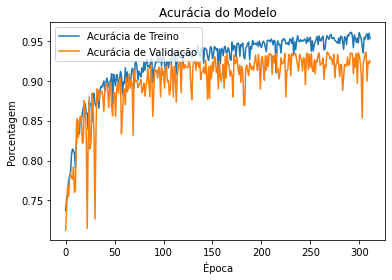

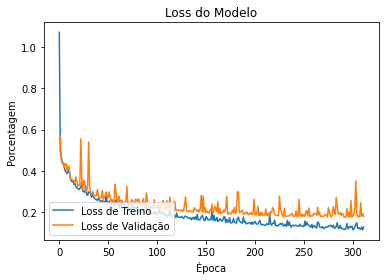

loss :  0.17802266776561737
accuracy :  0.9266968369483948


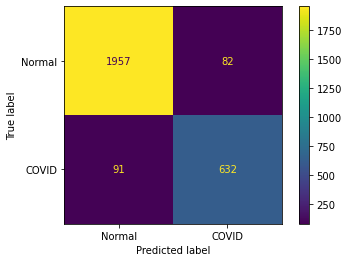

In [ ]:
show()

## Tentativa 2, com mais camadas densas

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 224, 224, 3)
(1105, 224, 224, 3)
(9941, 2)
(1105, 2)


In [ ]:
# Create an input layer with the shape of the input data
input_tensor = Input(shape=(img_size, img_size, channels))

# Instantiate the ResNet-50 model with pre-trained weights
model = models.Sequential()
model.add(ResNet50(weights='imagenet', input_tensor=input_tensor, include_top=False))
model.add(keras.layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes,activation = 'softmax'))
model.layers[0].trainable = False

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 22s 228ms/step - loss: 2.1211 - accuracy: 0.6379 - val_loss: 0.2001 - val_accuracy: 0.7385
Epoch 2/2000
39/39 [==============================] - 6s 146ms/step - loss: 0.1214 - accuracy: 0.7245 - val_loss: 0.0984 - val_accuracy: 0.7692
Epoch 3/2000
39/39 [==============================] - 6s 146ms/step - loss: 0.0992 - accuracy: 0.7492 - val_loss: 0.0938 - val_accuracy: 0.7647
Epoch 4/2000
39/39 [==============================] - 6s 146ms/step - loss: 0.0983 - accuracy: 0.7560 - val_loss: 0.0897 - val_accuracy: 0.7873
Epoch 5/2000
39/39 [==============================] - 6s 146ms/step - loss: 0.1029 - accuracy: 0.7499 - val_loss: 0.1113 - val_accuracy: 0.7249
Epoch 6/2000
39/39 [==============================] - 6s 147ms/step - loss: 0.0931 - accuracy: 0.7704 - val_loss: 0.0954 - val_accuracy: 0.7448
Epoch 7/2000
39/39 [==============================] - 6s 145ms/step - loss: 0.0852 - accuracy: 0.7913 - val_loss: 0.0875 - val_accuracy

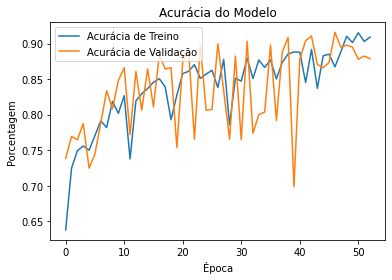

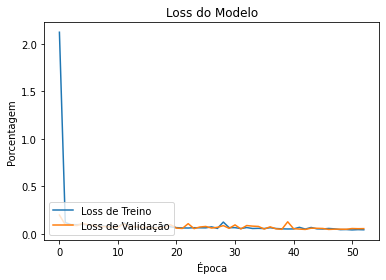

loss :  0.055331990122795105
accuracy :  0.8895927667617798


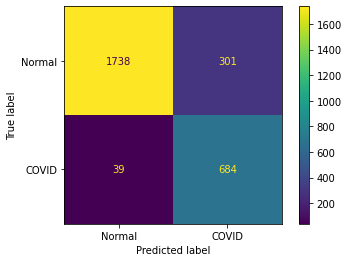

In [ ]:
show()

# ResNet-50 - 4 classes - Transfer Learning

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(21165, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(15238, 224, 224, 3)
(1694, 224, 224, 3)
(15238, 4)
(1694, 4)


In [ ]:
# Create an input layer with the shape of the input data
input_tensor = Input(shape=(img_size, img_size, channels))

# Instantiate the ResNet-50 model with pre-trained weights
model = models.Sequential()
model.add(ResNet50(weights='imagenet', input_tensor=input_tensor, include_top=False))
model.add(keras.layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes,activation = 'softmax'))
model.layers[0].trainable = False

# Compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train()

Epoch 1/2000
60/60 [==============================] - 25s 204ms/step - loss: 1.3262 - accuracy: 0.4046 - val_loss: 0.0940 - val_accuracy: 0.5791
Epoch 2/2000
60/60 [==============================] - 9s 146ms/step - loss: 0.0900 - accuracy: 0.5831 - val_loss: 0.0852 - val_accuracy: 0.6157
Epoch 3/2000
60/60 [==============================] - 9s 147ms/step - loss: 0.0846 - accuracy: 0.5978 - val_loss: 0.0790 - val_accuracy: 0.6535
Epoch 4/2000
60/60 [==============================] - 9s 146ms/step - loss: 0.0825 - accuracy: 0.6191 - val_loss: 0.0801 - val_accuracy: 0.6871
Epoch 5/2000
60/60 [==============================] - 9s 146ms/step - loss: 0.0797 - accuracy: 0.6397 - val_loss: 0.0818 - val_accuracy: 0.6139
Epoch 6/2000
60/60 [==============================] - 9s 145ms/step - loss: 0.0789 - accuracy: 0.6391 - val_loss: 0.0774 - val_accuracy: 0.6871
Epoch 7/2000
60/60 [==============================] - 9s 145ms/step - loss: 0.0752 - accuracy: 0.6622 - val_loss: 0.0697 - val_accuracy

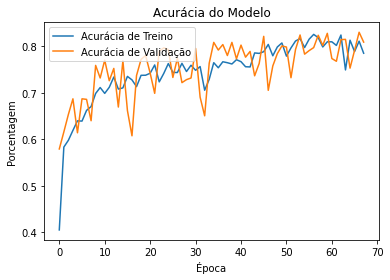

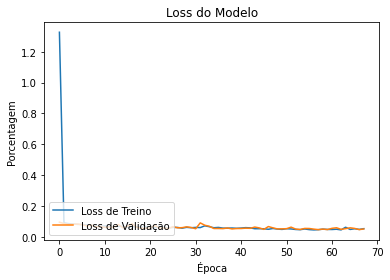

loss :  0.0493551641702652
accuracy :  0.8170011639595032


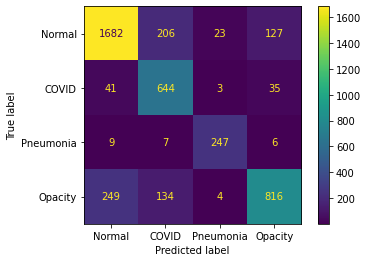

In [ ]:
show()

# DENSENET-201 - Transfer Learning

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 224, 224, 3)
(1105, 224, 224, 3)
(9941, 2)
(1105, 2)


## Tentativa 1

In [ ]:
model = models.Sequential()
model.add(DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels)))
model.add(keras.layers.Flatten())
model.add(layers.Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 2)                 188162    
                                                                 
Total params: 18,510,146
Trainable params: 188,162
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = learning_patience)
history = model.fit(x_train, y_train, 
                          epochs = epochs, batch_size = batch_size,  
                          validation_data = (x_val, y_val),
                          callbacks = [es])

Epoch 1/2000
39/39 [==============================] - 37s 398ms/step - loss: 1.4646 - accuracy: 0.8381 - val_loss: 0.4129 - val_accuracy: 0.9131
Epoch 2/2000
39/39 [==============================] - 8s 205ms/step - loss: 0.1764 - accuracy: 0.9565 - val_loss: 0.1124 - val_accuracy: 0.9611
Epoch 3/2000
39/39 [==============================] - 8s 205ms/step - loss: 0.0706 - accuracy: 0.9782 - val_loss: 0.0822 - val_accuracy: 0.9729
Epoch 4/2000
39/39 [==============================] - 8s 205ms/step - loss: 0.0458 - accuracy: 0.9873 - val_loss: 0.0665 - val_accuracy: 0.9792
Epoch 5/2000
39/39 [==============================] - 8s 207ms/step - loss: 0.0349 - accuracy: 0.9913 - val_loss: 0.0630 - val_accuracy: 0.9774
Epoch 6/2000
39/39 [==============================] - 8s 204ms/step - loss: 0.0275 - accuracy: 0.9940 - val_loss: 0.0629 - val_accuracy: 0.9801
Epoch 7/2000
39/39 [==============================] - 8s 209ms/step - loss: 0.0228 - accuracy: 0.9962 - val_loss: 0.0619 - val_accuracy

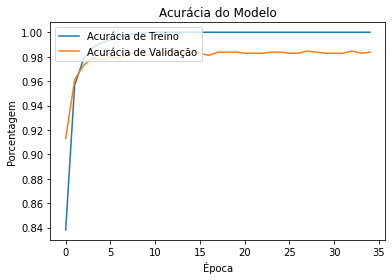

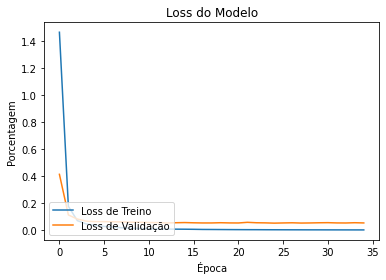

loss :  0.053218405693769455
accuracy :  0.9837104082107544


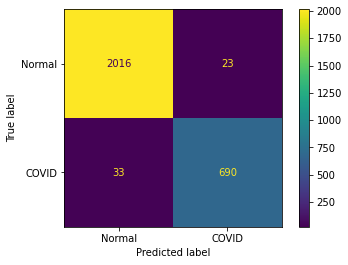

In [ ]:
show()

## Tentativa 2

In [ ]:
model = models.Sequential()
model.add(DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels)))
model.add(keras.layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 94080)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              96338944  
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 115,186,754
Trainable params: 96,864,770
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 37s 441ms/step - loss: 4.3225 - accuracy: 0.8222 - val_loss: 0.2248 - val_accuracy: 0.9285
Epoch 2/2000
39/39 [==============================] - 9s 237ms/step - loss: 0.0679 - accuracy: 0.9589 - val_loss: 0.0388 - val_accuracy: 0.9647
Epoch 3/2000
39/39 [==============================] - 9s 239ms/step - loss: 0.0155 - accuracy: 0.9812 - val_loss: 0.0244 - val_accuracy: 0.9701
Epoch 4/2000
39/39 [==============================] - 9s 239ms/step - loss: 0.0077 - accuracy: 0.9888 - val_loss: 0.0203 - val_accuracy: 0.9701
Epoch 5/2000
39/39 [==============================] - 9s 236ms/step - loss: 0.0036 - accuracy: 0.9962 - val_loss: 0.0344 - val_accuracy: 0.9611
Epoch 6/2000
39/39 [==============================] - 9s 237ms/step - loss: 0.0032 - accuracy: 0.9974 - val_loss: 0.0213 - val_accuracy: 0.9710
Epoch 7/2000
39/39 [==============================] - 9s 238ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0189 - val_accuracy

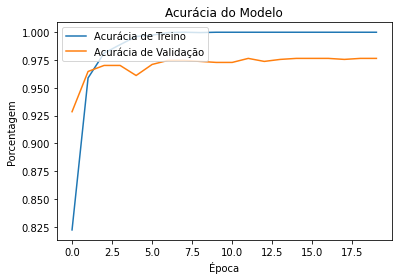

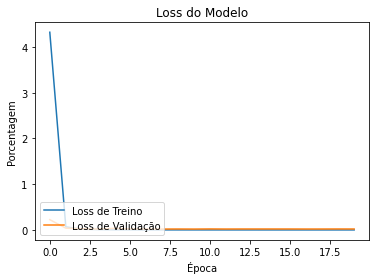

loss :  0.02026885561645031
accuracy :  0.9764705896377563


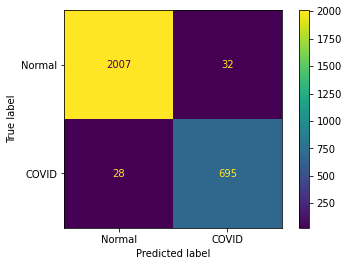

In [ ]:
show()

# Densenet 3 classes

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(15153, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10909, 224, 224, 3)
(1213, 224, 224, 3)
(10909, 3)
(1213, 3)


In [ ]:
model = models.Sequential()
model.add(DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels)))
model.add(keras.layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
train()

Epoch 1/2000
43/43 [==============================] - 38s 401ms/step - loss: 1.8654 - accuracy: 0.8125 - val_loss: 0.0935 - val_accuracy: 0.9167
Epoch 2/2000
43/43 [==============================] - 9s 205ms/step - loss: 0.0317 - accuracy: 0.9623 - val_loss: 0.0242 - val_accuracy: 0.9530
Epoch 3/2000
43/43 [==============================] - 9s 205ms/step - loss: 0.0116 - accuracy: 0.9824 - val_loss: 0.0198 - val_accuracy: 0.9621
Epoch 4/2000
43/43 [==============================] - 9s 205ms/step - loss: 0.0066 - accuracy: 0.9875 - val_loss: 0.0192 - val_accuracy: 0.9613
Epoch 5/2000
43/43 [==============================] - 9s 206ms/step - loss: 0.0036 - accuracy: 0.9941 - val_loss: 0.0176 - val_accuracy: 0.9637
Epoch 6/2000
43/43 [==============================] - 9s 204ms/step - loss: 0.0024 - accuracy: 0.9975 - val_loss: 0.0170 - val_accuracy: 0.9670
Epoch 7/2000
43/43 [==============================] - 9s 206ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0172 - val_accuracy

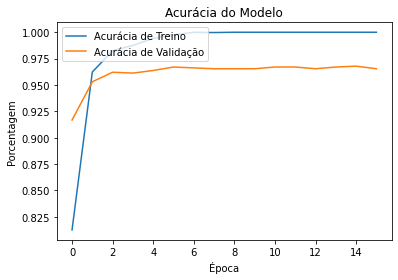

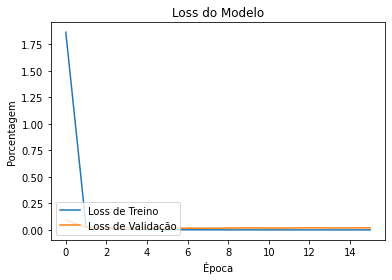

loss :  0.019864404574036598
accuracy :  0.9653751254081726


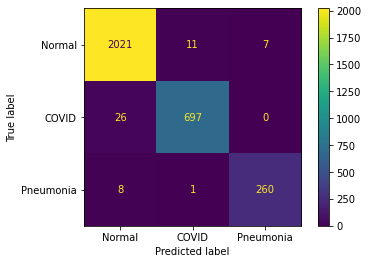

In [ ]:
show()

# DENSENET-201 BALANCED

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset(balance=True)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(12545, 224, 224, 3)
(1105, 224, 224, 3)
(12545, 2)
(1105, 2)


In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling2D layer and a fully connected layer to the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(n_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
train()

Epoch 1/2000
50/50 [==============================] - 26s 308ms/step - loss: 0.0964 - accuracy: 0.8654 - val_loss: 0.0615 - val_accuracy: 0.8805
Epoch 2/2000
50/50 [==============================] - 11s 228ms/step - loss: 0.0448 - accuracy: 0.9175 - val_loss: 0.0405 - val_accuracy: 0.9267
Epoch 3/2000
50/50 [==============================] - 11s 230ms/step - loss: 0.0306 - accuracy: 0.9459 - val_loss: 0.0347 - val_accuracy: 0.9376
Epoch 4/2000
50/50 [==============================] - 11s 227ms/step - loss: 0.0247 - accuracy: 0.9549 - val_loss: 0.0289 - val_accuracy: 0.9520
Epoch 5/2000
50/50 [==============================] - 11s 230ms/step - loss: 0.0233 - accuracy: 0.9582 - val_loss: 0.0430 - val_accuracy: 0.9195
Epoch 6/2000
50/50 [==============================] - 11s 227ms/step - loss: 0.0192 - accuracy: 0.9670 - val_loss: 0.1765 - val_accuracy: 0.7502
Epoch 7/2000
50/50 [==============================] - 11s 227ms/step - loss: 0.0432 - accuracy: 0.9273 - val_loss: 0.0309 - val_ac

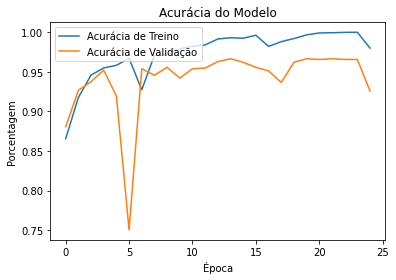

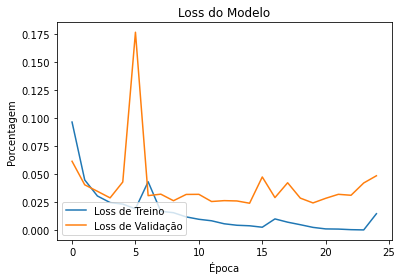

loss :  0.04856492951512337
accuracy :  0.92579185962677


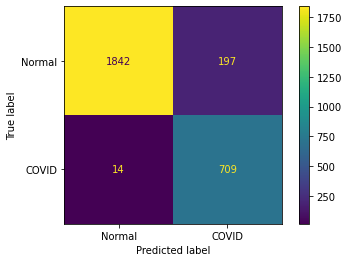

In [ ]:
show()

# SqueezeNet - Transfer Learning

In [ ]:
levels = ['Normal', 'COVID']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 20
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(13808, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(9941, 224, 224, 3)
(1105, 224, 224, 3)
(9941, 2)
(1105, 2)


In [ ]:
!pip install Keras-Applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.2 MB/s eta 0:00:00


In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
              print('Error')
                
    return model

In [ ]:
# Create an input layer with the shape of the input data
input_tensor = Input(shape=(img_size, img_size, channels))

model = models.Sequential()
#model.add(SqueezeNet(include_top=False, weights='imagenet'))
model.add(SqueezeNet( weights='imagenet',include_top=False, input_tensor=input_tensor,pooling='avg'))
model.add(layers.Dense(n_classes,activation = 'softmax'))
model.layers[0].trainable = False

# Compile the model
#model = SqueezeNet( weights=None, input_tensor=input_tensor,pooling='avg')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train()

Epoch 1/2000
39/39 [==============================] - 4s 87ms/step - loss: 0.1159 - accuracy: 0.7425 - val_loss: 0.1148 - val_accuracy: 0.7774
Epoch 2/2000
39/39 [==============================] - 3s 68ms/step - loss: 0.1080 - accuracy: 0.7503 - val_loss: 0.1049 - val_accuracy: 0.7638
Epoch 3/2000
39/39 [==============================] - 3s 67ms/step - loss: 0.1034 - accuracy: 0.7625 - val_loss: 0.1025 - val_accuracy: 0.7946
Epoch 4/2000
39/39 [==============================] - 3s 69ms/step - loss: 0.1009 - accuracy: 0.7746 - val_loss: 0.0999 - val_accuracy: 0.7928
Epoch 5/2000
39/39 [==============================] - 3s 69ms/step - loss: 0.1000 - accuracy: 0.7785 - val_loss: 0.0985 - val_accuracy: 0.7964
Epoch 6/2000
39/39 [==============================] - 3s 67ms/step - loss: 0.0979 - accuracy: 0.7866 - val_loss: 0.1006 - val_accuracy: 0.7792
Epoch 7/2000
39/39 [==============================] - 3s 66ms/step - loss: 0.0972 - accuracy: 0.7869 - val_loss: 0.0966 - val_accuracy: 0.7955

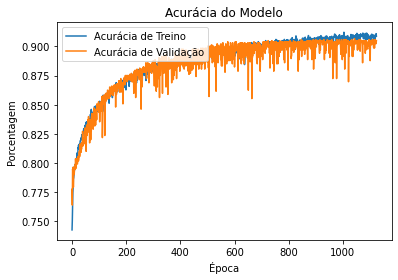

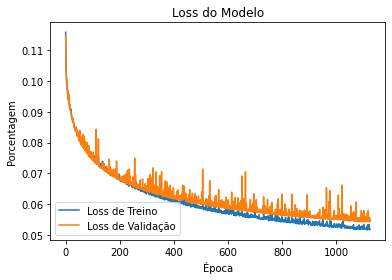

loss :  0.054883163422346115
accuracy :  0.9058823585510254


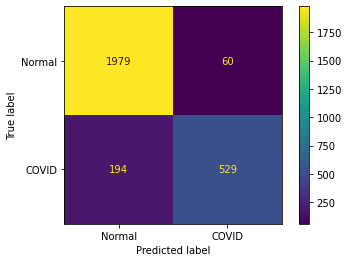

In [ ]:
show()

# SqueezeNet - 3 Classes

In [ ]:
levels = ['Normal', 'COVID', 'Viral Pneumonia']
img_size = 224
test_size = 0.2
validation_size = 0.1
channels = 3
learning_rate = 0.001
learning_patience = 10
epochs = 2000
batch_size = 256

In [ ]:
n_classes = len(levels)

read_dataset()
#read_dataset_v2()

print(x.shape)

(15153, 224, 224, 3)


In [ ]:
format_dataset()

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(10909, 224, 224, 3)
(1213, 224, 224, 3)
(10909, 3)
(1213, 3)


In [ ]:
# Create an input layer with the shape of the input data
input_tensor = Input(shape=(img_size, img_size, channels))

model = models.Sequential()
model.add(SqueezeNet( weights='imagenet',include_top=False, input_tensor=input_tensor,pooling='avg'))
model.add(layers.Dense(n_classes,activation = 'softmax'))
model.layers[0].trainable = False

3032184/3032184 [==============================] - 0s 0us/step


In [ ]:
train()

Epoch 1/2000
43/43 [==============================] - 5s 93ms/step - loss: 0.2798 - accuracy: 0.5440 - val_loss: 0.1005 - val_accuracy: 0.6735
Epoch 2/2000
43/43 [==============================] - 3s 63ms/step - loss: 0.0982 - accuracy: 0.6728 - val_loss: 0.0953 - val_accuracy: 0.6777
Epoch 3/2000
43/43 [==============================] - 3s 62ms/step - loss: 0.0940 - accuracy: 0.6757 - val_loss: 0.0922 - val_accuracy: 0.6760
Epoch 4/2000
43/43 [==============================] - 3s 63ms/step - loss: 0.0913 - accuracy: 0.6836 - val_loss: 0.0905 - val_accuracy: 0.6933
Epoch 5/2000
43/43 [==============================] - 3s 62ms/step - loss: 0.0891 - accuracy: 0.6878 - val_loss: 0.0882 - val_accuracy: 0.6966
Epoch 6/2000
43/43 [==============================] - 3s 62ms/step - loss: 0.0874 - accuracy: 0.6943 - val_loss: 0.0865 - val_accuracy: 0.7007
Epoch 7/2000
43/43 [==============================] - 3s 62ms/step - loss: 0.0858 - accuracy: 0.7020 - val_loss: 0.0849 - val_accuracy: 0.6958

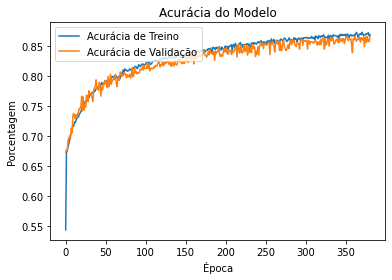

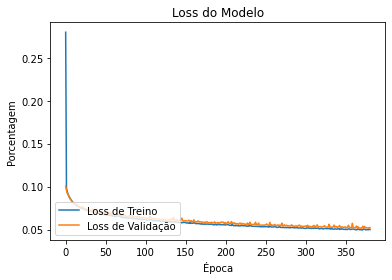

loss :  0.052172232419252396
accuracy :  0.8656224012374878


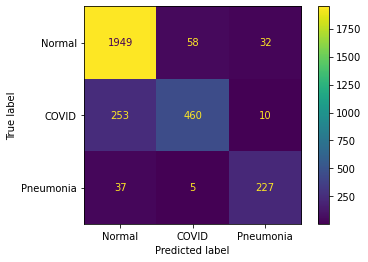

In [ ]:
show()